# Lab 6: Implementing Direct Policy Search

ENGS 199.20  
2025-11-07

## Overview

Today we’re going to compare open loop intertemporal and closed loop
(via direct policy search with a radial basis function) optimization.
This lab replicates and adapts various analyses in Quinn, J.D., Reed,
P.M., Keller, K. (2017). [Direct policy search for robust
multi-objective management of deeply uncertain socio-ecological tipping
points.](https://www.sciencedirect.com/science/article/pii/S1364815216302250)
Environmental Modelling & Software 92, 125-141.

Today’s objectives:

1.  Learn about Pareto optimal strategies for the simple lake problem
    obtained using the open loop and closed loop approaches  
2.  Evaluate and explain the solution dynamics from various strategies
    from both approaches
3.  Calculate performance metrics for different strategies
4.  Demonstrate your conceptual understanding of dynamic planning and
    how it relates to robustness
5.  Describe how you could incorporate dynamic planning into your
    decision analysis

## Lab Workflow

### Repository Setup

You can call the repository `dps_lab/`.

If you need a reminder on how to set up your project directory and
create a GitHub repository, check the workflow and directory structure
from lab 2.

You can directly export these lab instructions as a `.ipynb` file (look
at the top right of the page). I put this file file directly under my
`dps_lab/` dps directory. If you organize your directory different,
please update relative filepaths in the code below accordingly.

### Environment Setup

Environment wise, you can use the one we set up for the previous lab.

Be sure to include instructions in your `README.md` about how others can
prepare the computational environment to run your notebook.

### Our Analysis

Make sure your environment is set up and active to run the code cells
below.

#### Revised lake problem overview

Quinn et al., (2017) share the general concept of our problem statement
in Lab 4 but introduce a different representation of system dynamics,
new planning objectives, and new policy search approaches.

Due to ongoing economic activity, a town emits phosphorous into a
shallow lake (with a concentration of $a_t$), which also receives
non-point source runoff (concentration $y_t$) from the surrounding area.
The concentration of the lake at time $t+1$ is given by
$$X_{t+1} = X_t + a_t + y_t + \frac{X_t^q}{1+X_t^q} - bX_t,$$

where:

| Parameter | Value                                                |
|:---------:|:-----------------------------------------------------|
|   $a_t$   | point-source phosphorous concentration from the town |
|   $y_t$   | non-point-source phosphorous concentration           |
|    $q$    | rate at which phosphorous is recycled from sediment  |
|    $b$    | rate at which phosphorous leaves the lake            |

and $X_0 = 0$, $y_t \sim LogNormal(0.03, \sqrt(10^{-5}))$, $q=2.5$, and
$b=0.4$.

The goal of the optimization is to meet several objectices:

| Objective | Description | Preference |
|:-----------------------:|:---------------------|:-----------------------:|
| Economic Benefits | Discounted economic benefits, assumed proportional to discounted P emissions | Max |
| Lake P Concentration | Measure of the lake quality, where lower P concentrations correspond to clearer lakes | Min |
| Policy Inertia | Measure of the stability of the control policy, where stable policies are favored | Max |
| Reliability | Percentage of simulations that the lake P concentration is below the critical P threshold | Max |

Please consult Section 3.1 of the paper to see the mathematical
formulation of the objectives.

#### Non-linear dynamics in the shallow lake problem

Let’s take a closer look at the non-linear dynamics of the shallow lake
problem.

Each time step, the P concentration in the lake changes due to a natural
inflow (+), an anthropogenic contribution (+), P recycled from sediments
(+), and losses of P through outflow or sediment absorption (-). The
critical P threshold exists where natural P recycling exceeds natural P
losses as a function of the current P level in the lake. The paper has
this helpful figure that illustrates the dynamics and critical P
thresholds as a function of changing parameter values that determine
natural recycling and loss rates.

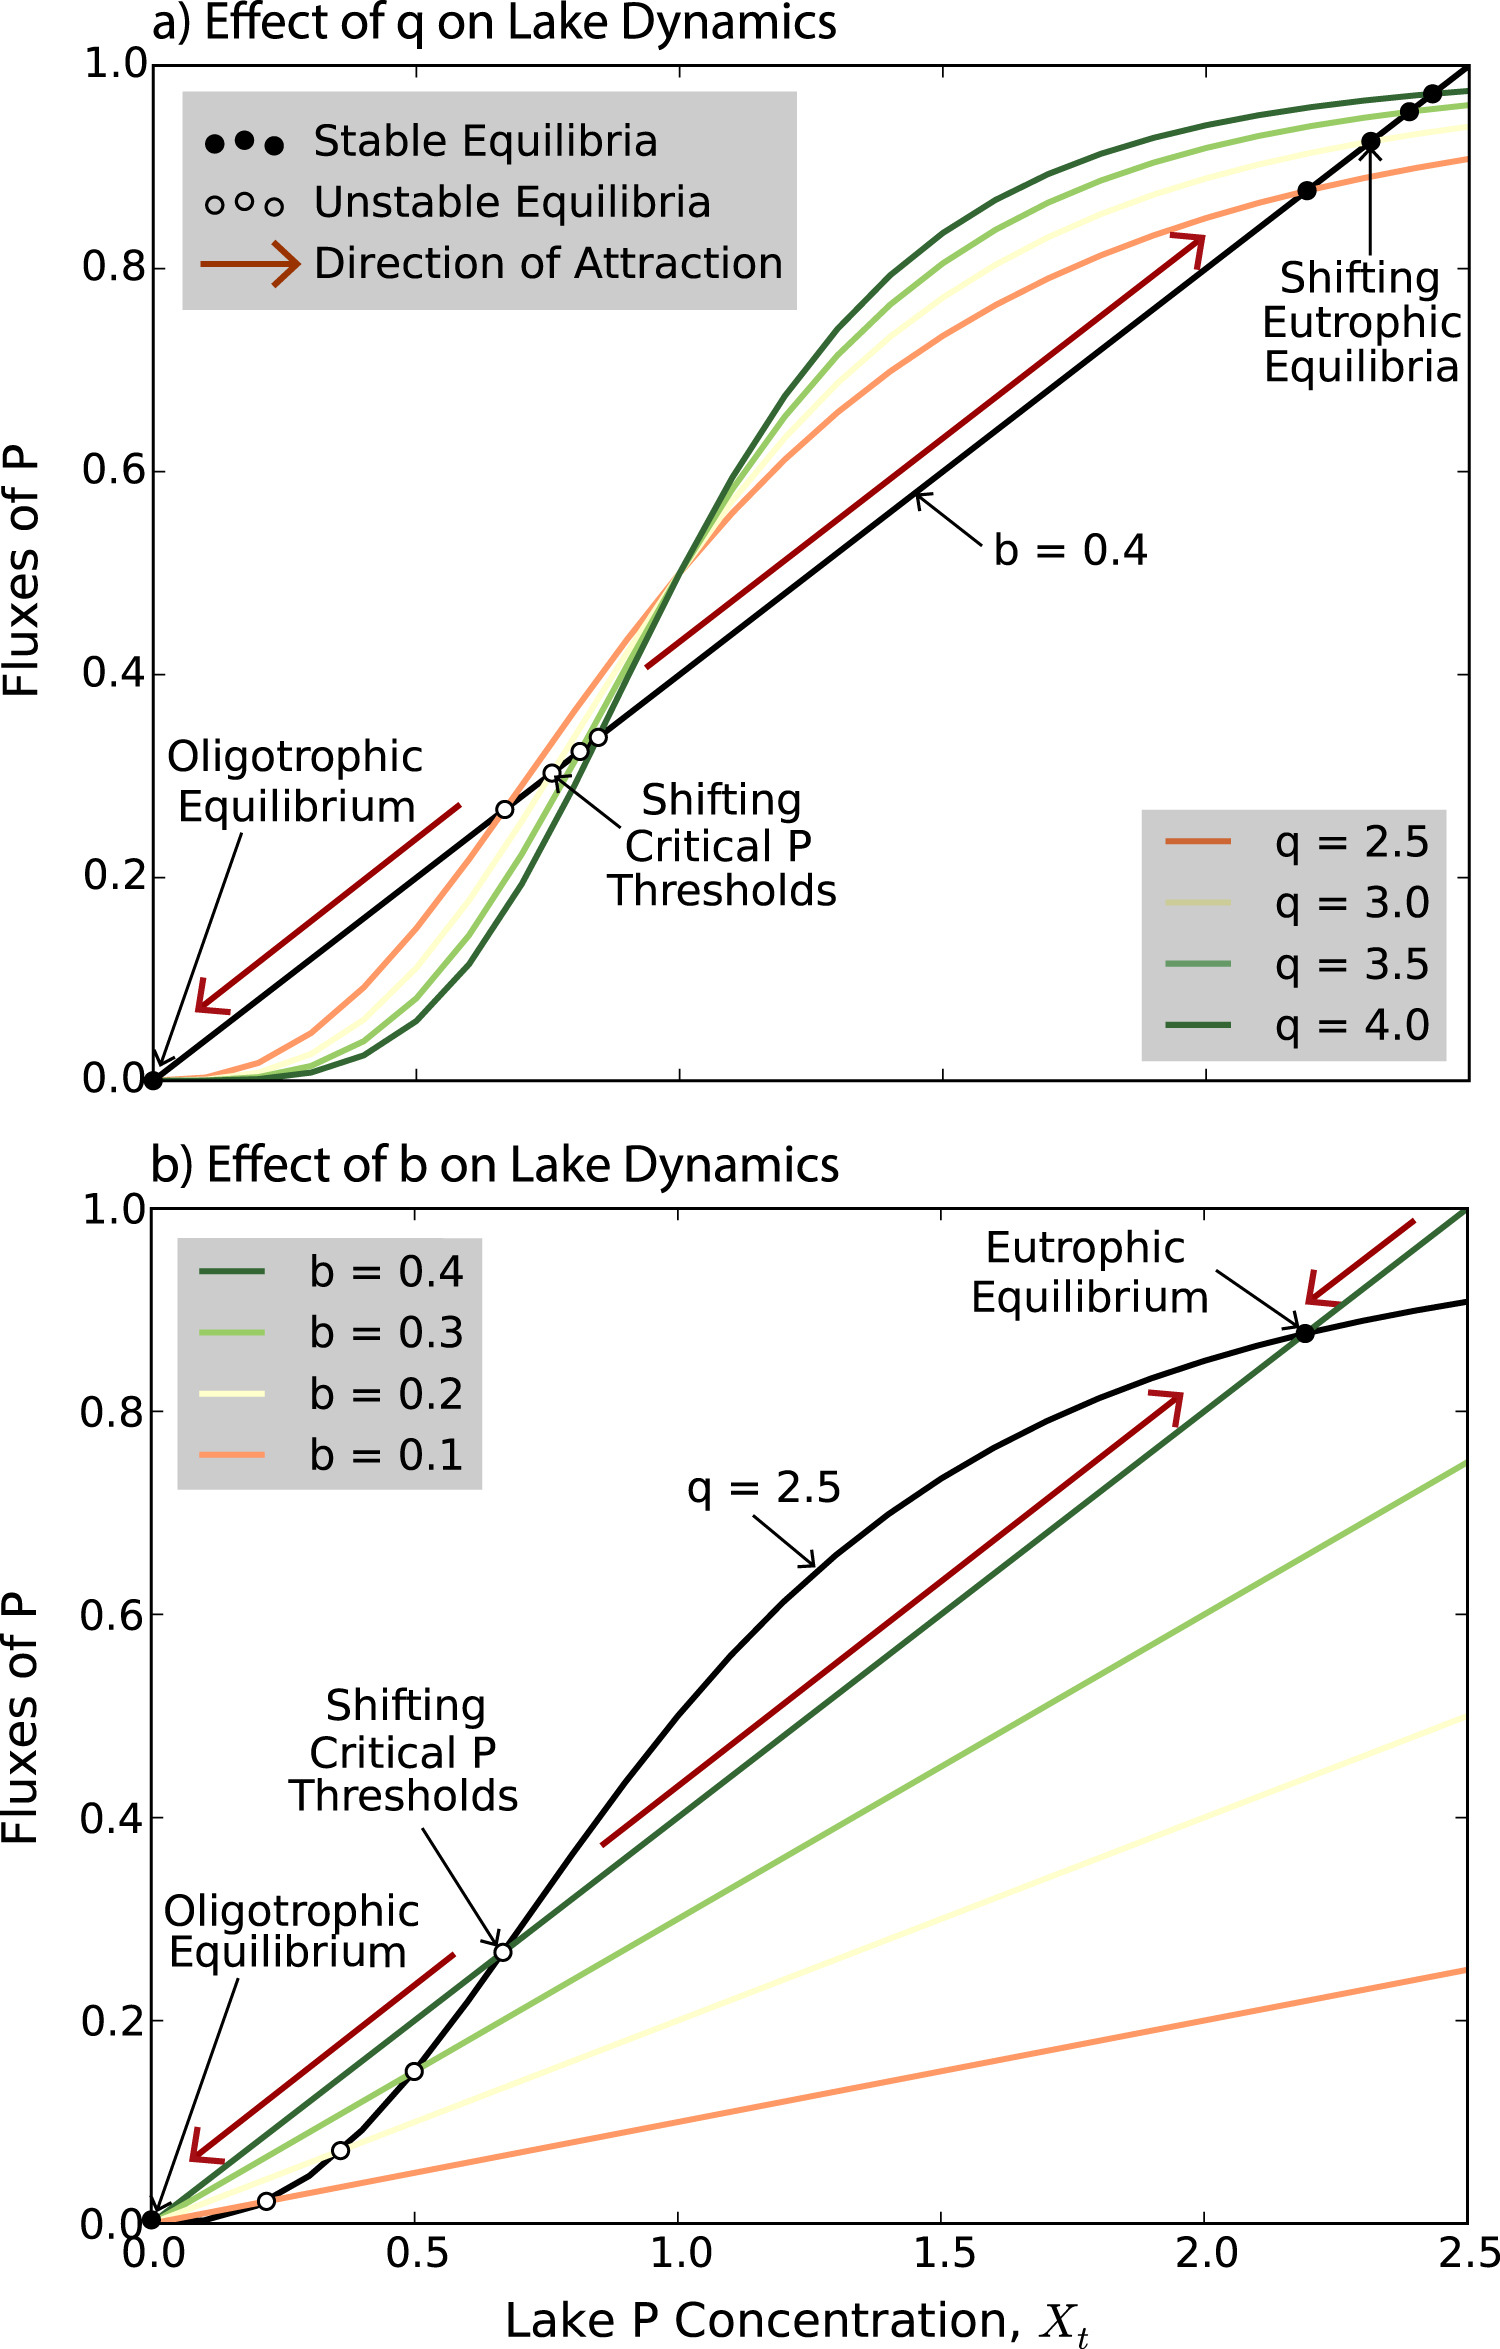

As posed in this and related studies, b & q are deeply uncertain
parameters. In a given state of the world, we can calculate critical P
by finding the roots (the values of X that make the equation equal to 0)
of: $\frac{X_t^q}{1+X_t^q} - bX_t$.

The intertemporal apporach will test out many possible combinations of
$a_t$ over 100 years. With enough training, this approach could find the
sequences of $a_t$ that are Pareto optimal and avoid the critical P
threshold of the considered SOW. However, keep in mind that there are
100 decision variables! With $.01 < a_t < .1, \forall t$, there are an
infeasible number of candidate solutions to test.

In contrast, by using direct policy search with radial basis functions,
we completely transform the decision space. Following Section 3.2.2, we
now represent the decision levers as: $$
a_{t, i} = \min(\max(\sum_{j=1}^n w_j |\frac{X_{t,i} - c_j}{r_j}|^3, 0.01),0.1) \quad \forall {t, i}
$$

This is a cubic radial basis function that parameterizes how to map P
concentrations to P release decisions. $c_j$, $r_j$ and $w_j$ are the
centers, radii, and weights of *n* cubic radial basis functions. The
decision variables are these $3*n$ parameters, rather than the *T*
decision variables in the intertemporal optimization. The authors used 2
radial basis functions in this study, so the DPS and intertemporal
approaches consider 6 vs. 100 decision variables, respectively. The
authors emphasize – and this is important! – that with the DPS approach,
different P release decisions can be made in each of the N simulations
(note the *i* indexing) because the decisions are informed by the lake P
concentrations in a time step. We are searching for the values of $c_1$,
$r_1$, $w_1$, $c_2$, $r_2$, and $w_2$.

In addition to evaluating open loop vs. closed loop strategies for their
expected performance on objectives (and how robustly they do well on
objectives across SOWs), we are going to pay close attention to how the
various strategies act as the P level in the lake gets close to the
critical P threshold in both the SOW the policy was trained on and in
new SOWs.

#### Comparing Intertemporal and DPS

Instead of running the optimization (which takes a very long time), we
are fortunate that we can directly use the reuslts from Quinn et al.,
(2017) due to their very well-formatted
[repository](https://github.com/julianneq/Lake_Problem_DPS). Download
the repo, which you can do
[here](https://codeload.github.com/julianneq/Lake_Problem_DPS/zip/refs/heads/master),
and extract the data from the `DataInPaper` subdirectory. I created a
subdirectory called `data` which is at the same level in the lab
directory as my `.ipynb` file. I put all the contents of `DataInPaper`
into `data`.

To help build intuition about how the optimization works, we’ll break
down the process a bit.

Firt, let’s orient ourselves to the state of the world the optimization
takes place in.

In [1]:
import math
import numpy as np

# Lake model parameters, number of years simulated, and number of samples generated
q = 2
b = 0.42
alpha = 0.4
delta = 0.98
mu = 0.03
sigma = np.sqrt(10**(-5.0))
lake0 = 0
nYears = 100
nSamples = 100

We can find the critical P threshold by identifying the value of X at
which the natural P recycling and losses are equal to each other:
$\frac{X^q}{1+X^q} - bX = 0$ -\> $\frac{X^2}{1+X^2} - .42*X = 0$. There
are several options to calculate this in python. We will use Brent’s
method as implemented in `scipy`.

Critical P: 0.5445

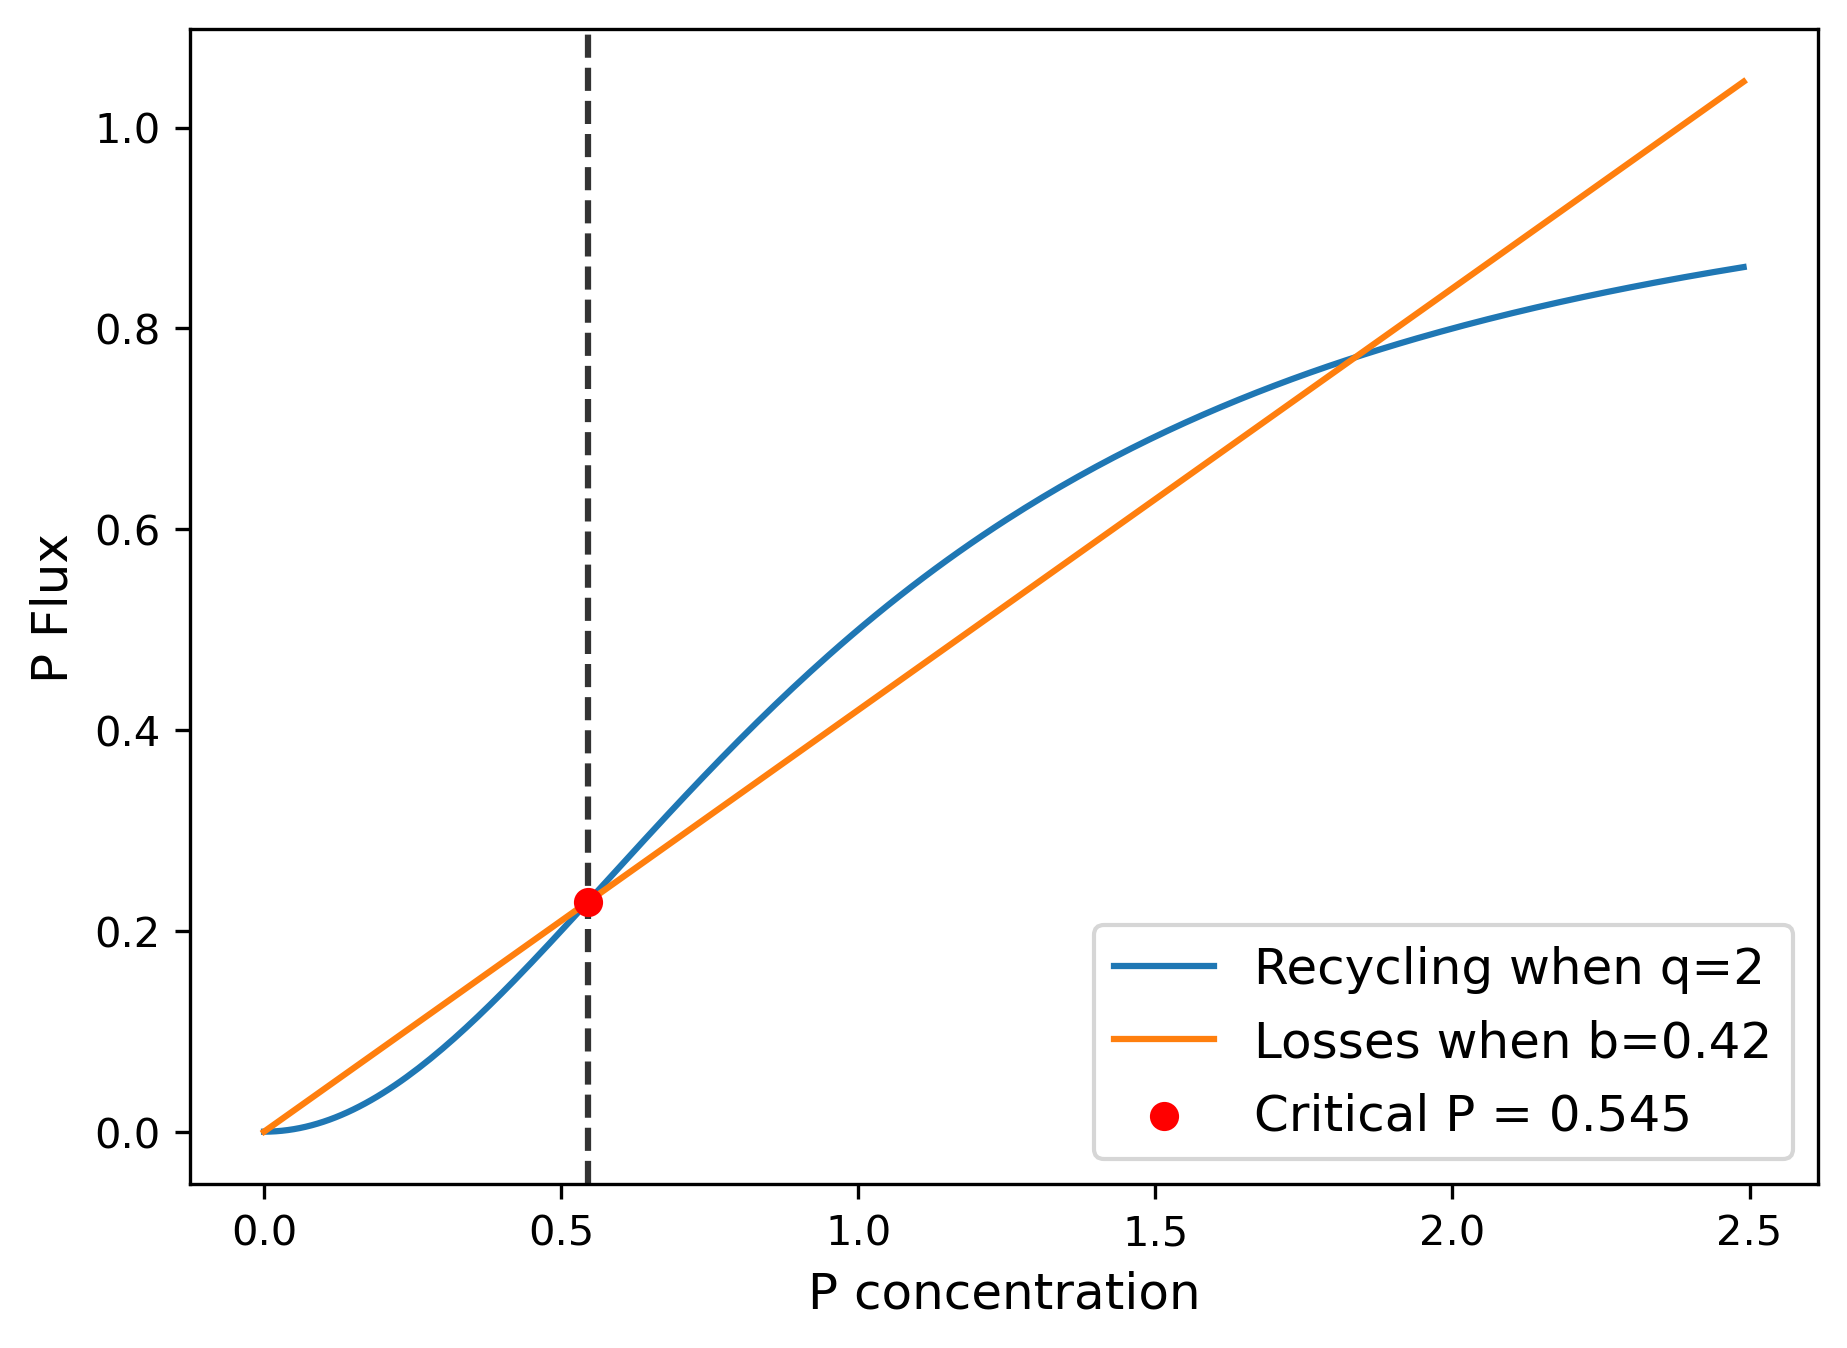

In [2]:
from scipy.optimize import brentq
import matplotlib.pyplot as plt

xs = np.arange(0, 2.5, 0.01)

def recycling(x, q=q):
    return x**q / (1.0 + x**q)

def losses(x, b=b):
    return b * x

R = recycling(xs)
L = losses(xs)

p_crit = brentq(lambda x: x**q / (1 + x**q) - b * x, 0.01, 1.5)

fig, ax = plt.subplots(dpi=300)
ax.plot(xs, R, label="Recycling when q={}".format(q), color="C0")
ax.plot(xs, L, label="Losses when b={}".format(b), color="C1")
ax.axvline(p_crit, color="k", linestyle="--", alpha=0.8)
ax.scatter([p_crit], [recycling(p_crit)], color="red", zorder=5, label=f"Critical P = {p_crit:.3f}")
ax.set_xlabel("P concentration", size=12)
ax.set_ylabel("P Flux", size=12)
ax.legend(fontsize='large')

print(f"Critical P: {p_crit:.4f}")

Pay attention to the gap between losses and recycling in this state of
the world to the left of the unstable equilibrium.

When we do intertemporal optimization, we are considering anthropogenic
releases between 0.01 and 0.1 at each time step. Crucially, we are
considering the full sequence of those releases over 100 time steps. In
the MOEA framework, the optimization considers a candidate sequence of
100 releases and tests this against each simulation of natural inflows
(because this is stochastic). The optimization looks for the candidate
sequences that do “best” on the expected value of the multiple
objectives. Then, it continues searching based on the EA design.

Let’s take a closer look at the intertemporal strategies highlighted in
the paper that are best on the reliability and benefits objectives,
respecitvely.

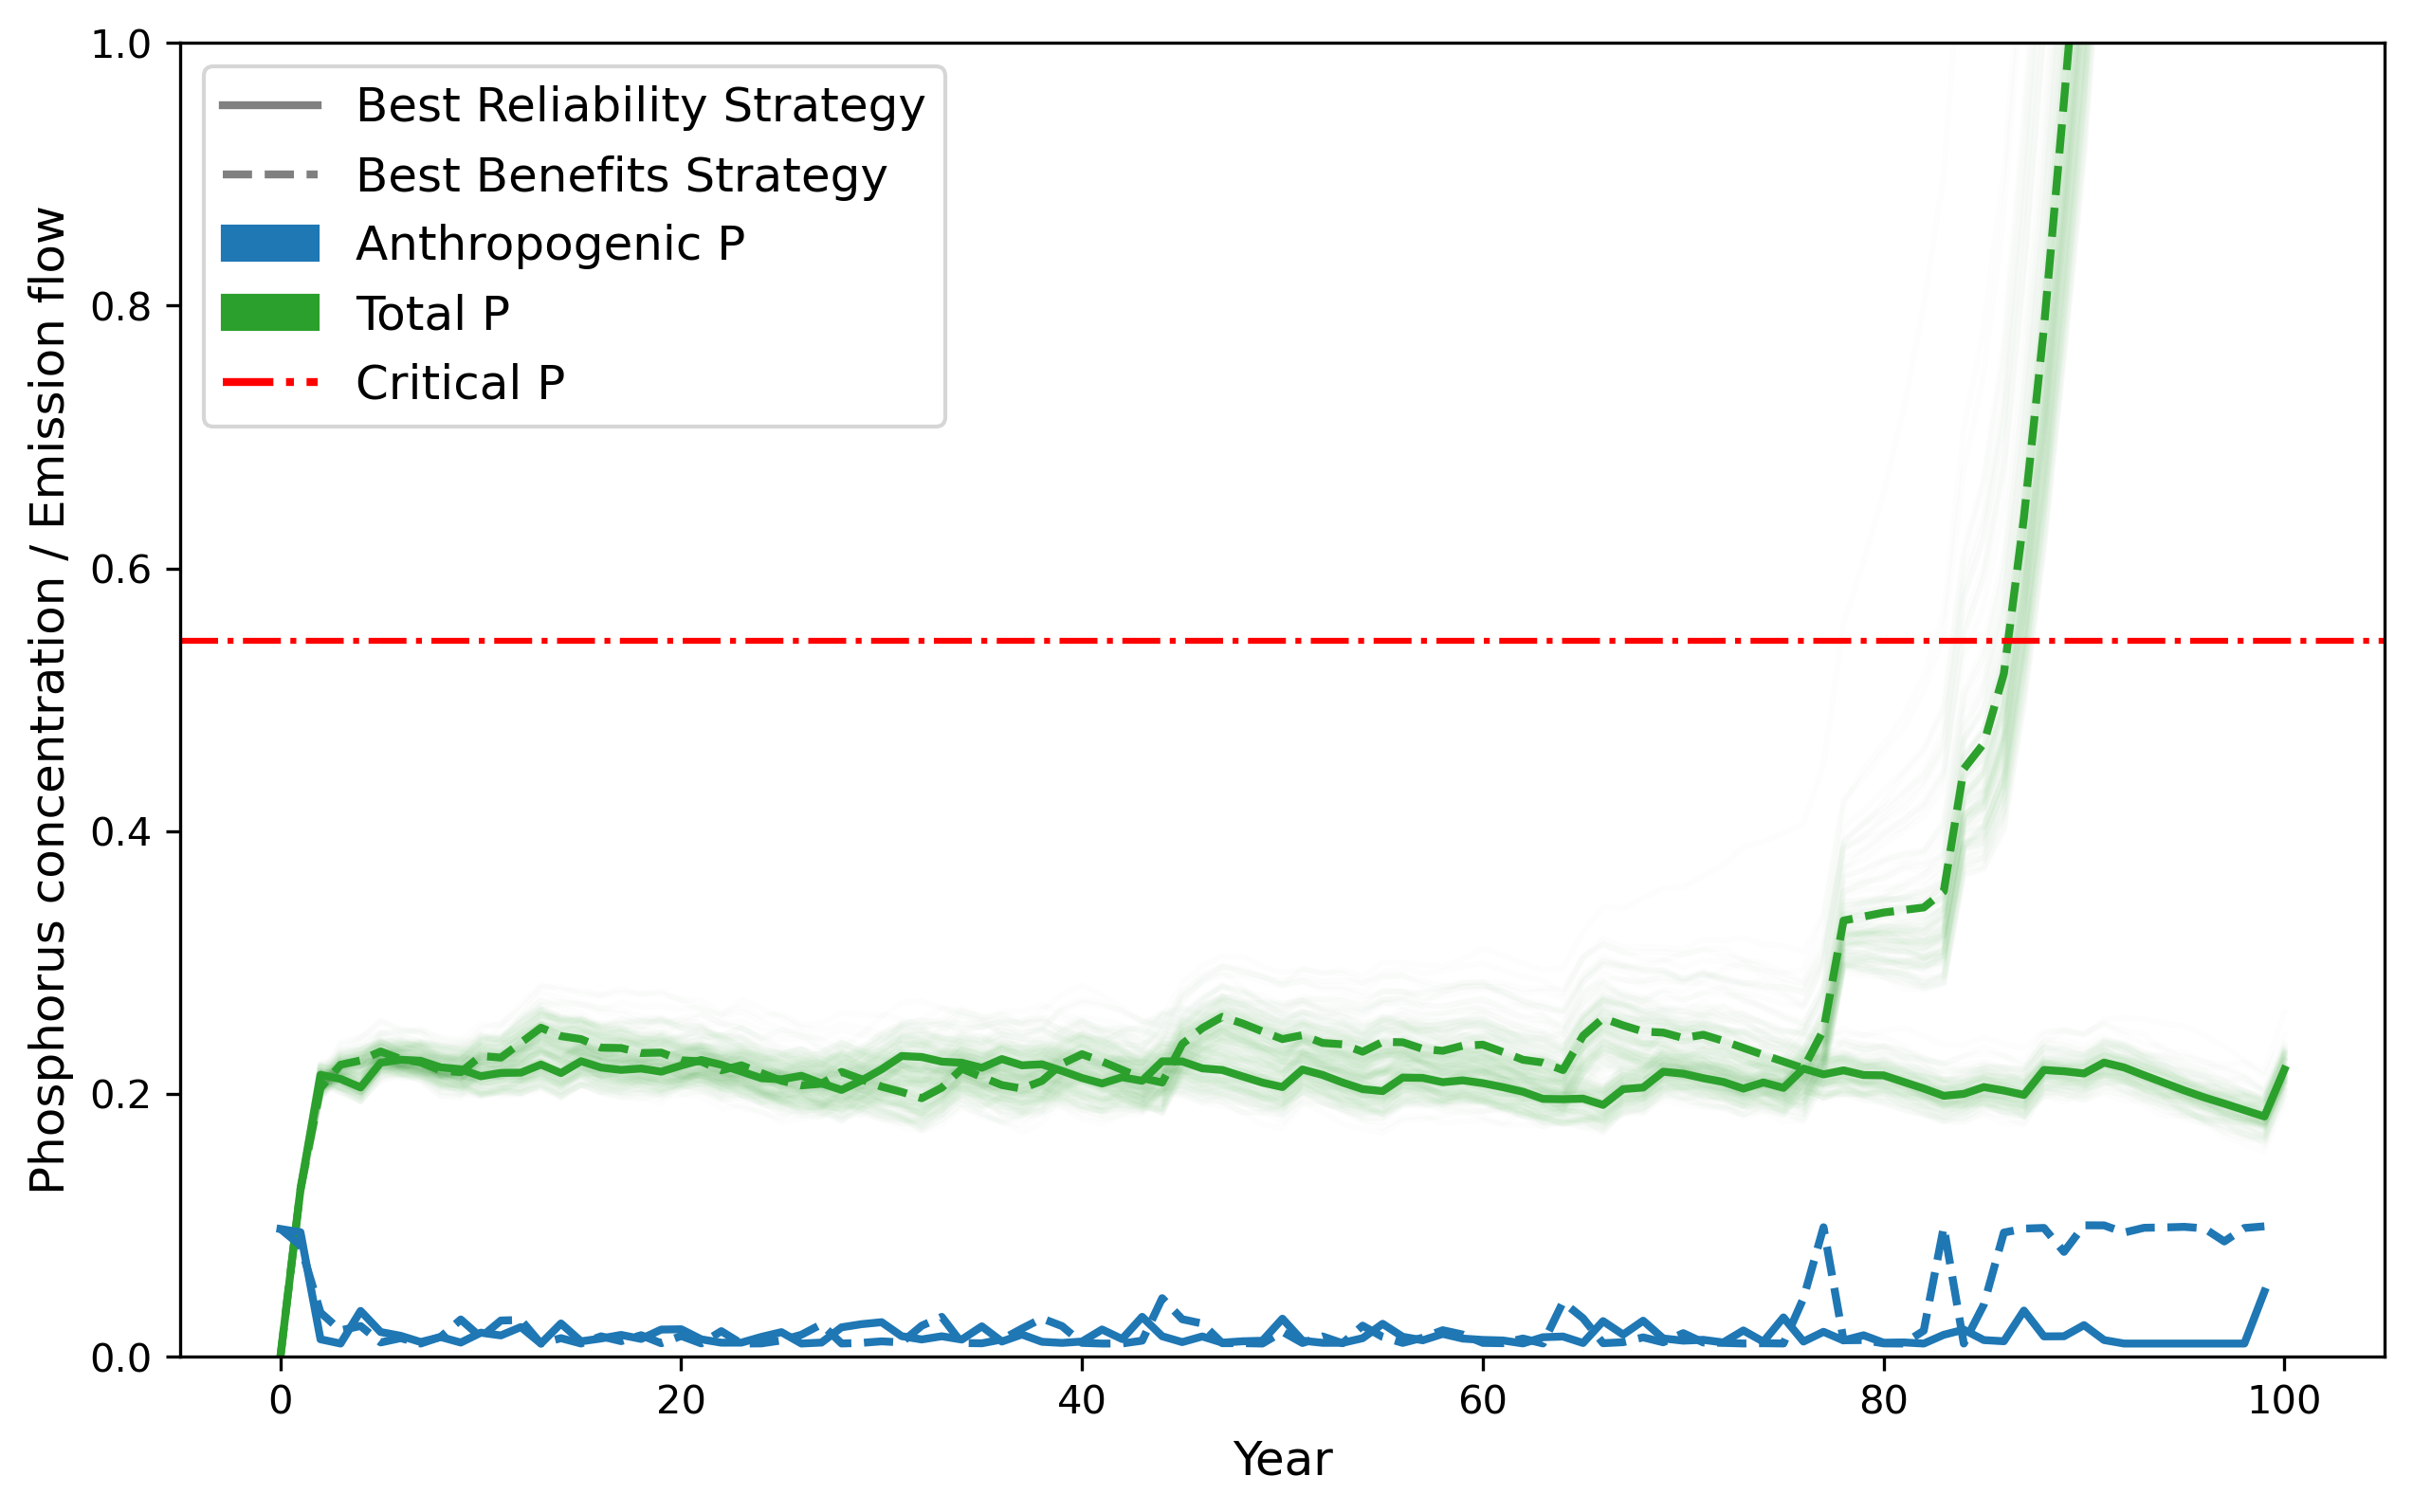

In [3]:
import scipy.stats as ss

# Intertemporal lake problem
# We set a seed for consistent results with the paper
# We pass in the 100 actions for the strategy
def LakeModel_IT(seed, actions):
    # Set inflow distribution parameters
    log_std = np.sqrt(np.log(1+sigma**2/mu**2))
    log_mu = np.log(mu) - 0.5*(log_std**2)
    
    # Initialize arrays to store P level in the lake at each time step
    lake_state = np.zeros([nYears+1])

    # Randomly generate nSamples of nYears of natural P inflows
    natFlow = np.zeros([nYears])
    np.random.seed(seed)
    natFlow= np.exp(ss.norm.rvs(log_mu, log_std, nYears))
    
    # Run lake model simulation
    lake_state[0] = lake0
    for i in range(nYears):
        lake_state[i+1] = lake_state[i]*(1-b) + (lake_state[i]**q)/(1+(lake_state[i]**q)) + actions[i] + natFlow[i]

    # Return natural inflows and actions as well      
    return (lake_state, natFlow, actions)

# Load the intertemporal results

# The rows are different strategies
# The first 100 columns are the actions
# The remaining columns are objective values, calculated
# as expected values over the simulated natural inflows
# The last column is the reliability objective
IT = np.loadtxt('./data/Intertemporal/Intertemporal.resultfile')

# The best reliability strategy minimizes the percentage of
# simulations within a SOW where we pass critical P
ITmostRel = np.argmin(IT[:,103]) 
# The best benefits strategy maximizes net present value
ITmostBen = np.argmin(IT[:,100])

years = np.arange(nYears + 1)

mostRel_states_all = []
mostBen_states_all = []

fig, ax = plt.subplots(figsize=(10, 6),
                       dpi=300)

for sim in range(nSamples):
    IT_states_mostRel = LakeModel_IT(sim, IT[ITmostRel, 0:100])
    IT_states_mostBen = LakeModel_IT(sim, IT[ITmostBen, 0:100])
    mostRel_states_all.append(IT_states_mostRel[0])
    mostBen_states_all.append(IT_states_mostBen[0])
    
    # Plot total P time series with low alpha for clarity
    ax.plot(years, IT_states_mostRel[0], color='tab:green', alpha=0.01)
    ax.plot(years, IT_states_mostBen[0], color='tab:green', alpha=0.01)

# Plot mean total P for both strategies
ax.plot(years, np.array(mostRel_states_all).mean(axis=0), color='tab:green', lw=2, ls='-')
ax.plot(years, np.array(mostBen_states_all).mean(axis=0), color='tab:green', ls='--', lw=2)

# Plot actions (anthropogenic emissions) for both strategies
ax.plot(years[:-1], IT_states_mostRel[2], color='tab:blue', lw=2, ls='-')
ax.plot(years[:-1], IT_states_mostBen[2], color='tab:blue', lw=2, ls='--')

# Critical phosphorus concentration line
ax.axhline(p_crit, color='red', ls='-.', label='Critical P (threshold)')

# Labels and title
ax.set_xlabel('Year', size=12)
ax.set_ylabel('Phosphorus concentration / Emission flow', size=12)
ax.set_ylim([0, 1])

# Custom legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='gray', lw=2, ls='-', label='Best Reliability Strategy'),
                   Line2D([0], [0], color='gray', lw=2, ls='--', label='Best Benefits Strategy'),
                   Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='Anthropogenic P'),
                   Patch(facecolor='tab:green', edgecolor='tab:green',
                         label='Total P'),
                   Line2D([0], [0], color='red', lw=2, ls='-.', label='Critical P'),]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize='large')

Note that in order to see the anthropogenic P lines, I clipped the upper
y limit, which goes well above 1 for Total P in the best benefits
strategy case!

Both strategies are assessed over identical natural P inflow
realizations. What do you recognize about the different strategy
behaviors?

As an exercise, add subplots the P Flux from the natural P recycling and
losses for each strategy across each realization. What do you notice
about how the best benefits strategy manages the non-linear dynamics
past the critical P threshold? Check equations 6-9 in the paper, which
describe the intertemporal optimizaton, and explain how mathematical
formulation choices influence the dynamics of the best benefits
strategy. (Hint: consider constraints and the time horizon).

Now, let’s take a look at the analagous policies the authors found with
direct policy search. We’ll look at the state-action mappings from each
as well as how that plays out over time.

To start, we’ll plot the best reliability and benefits strategies:

Text(0.5, 0, 'Lake P')

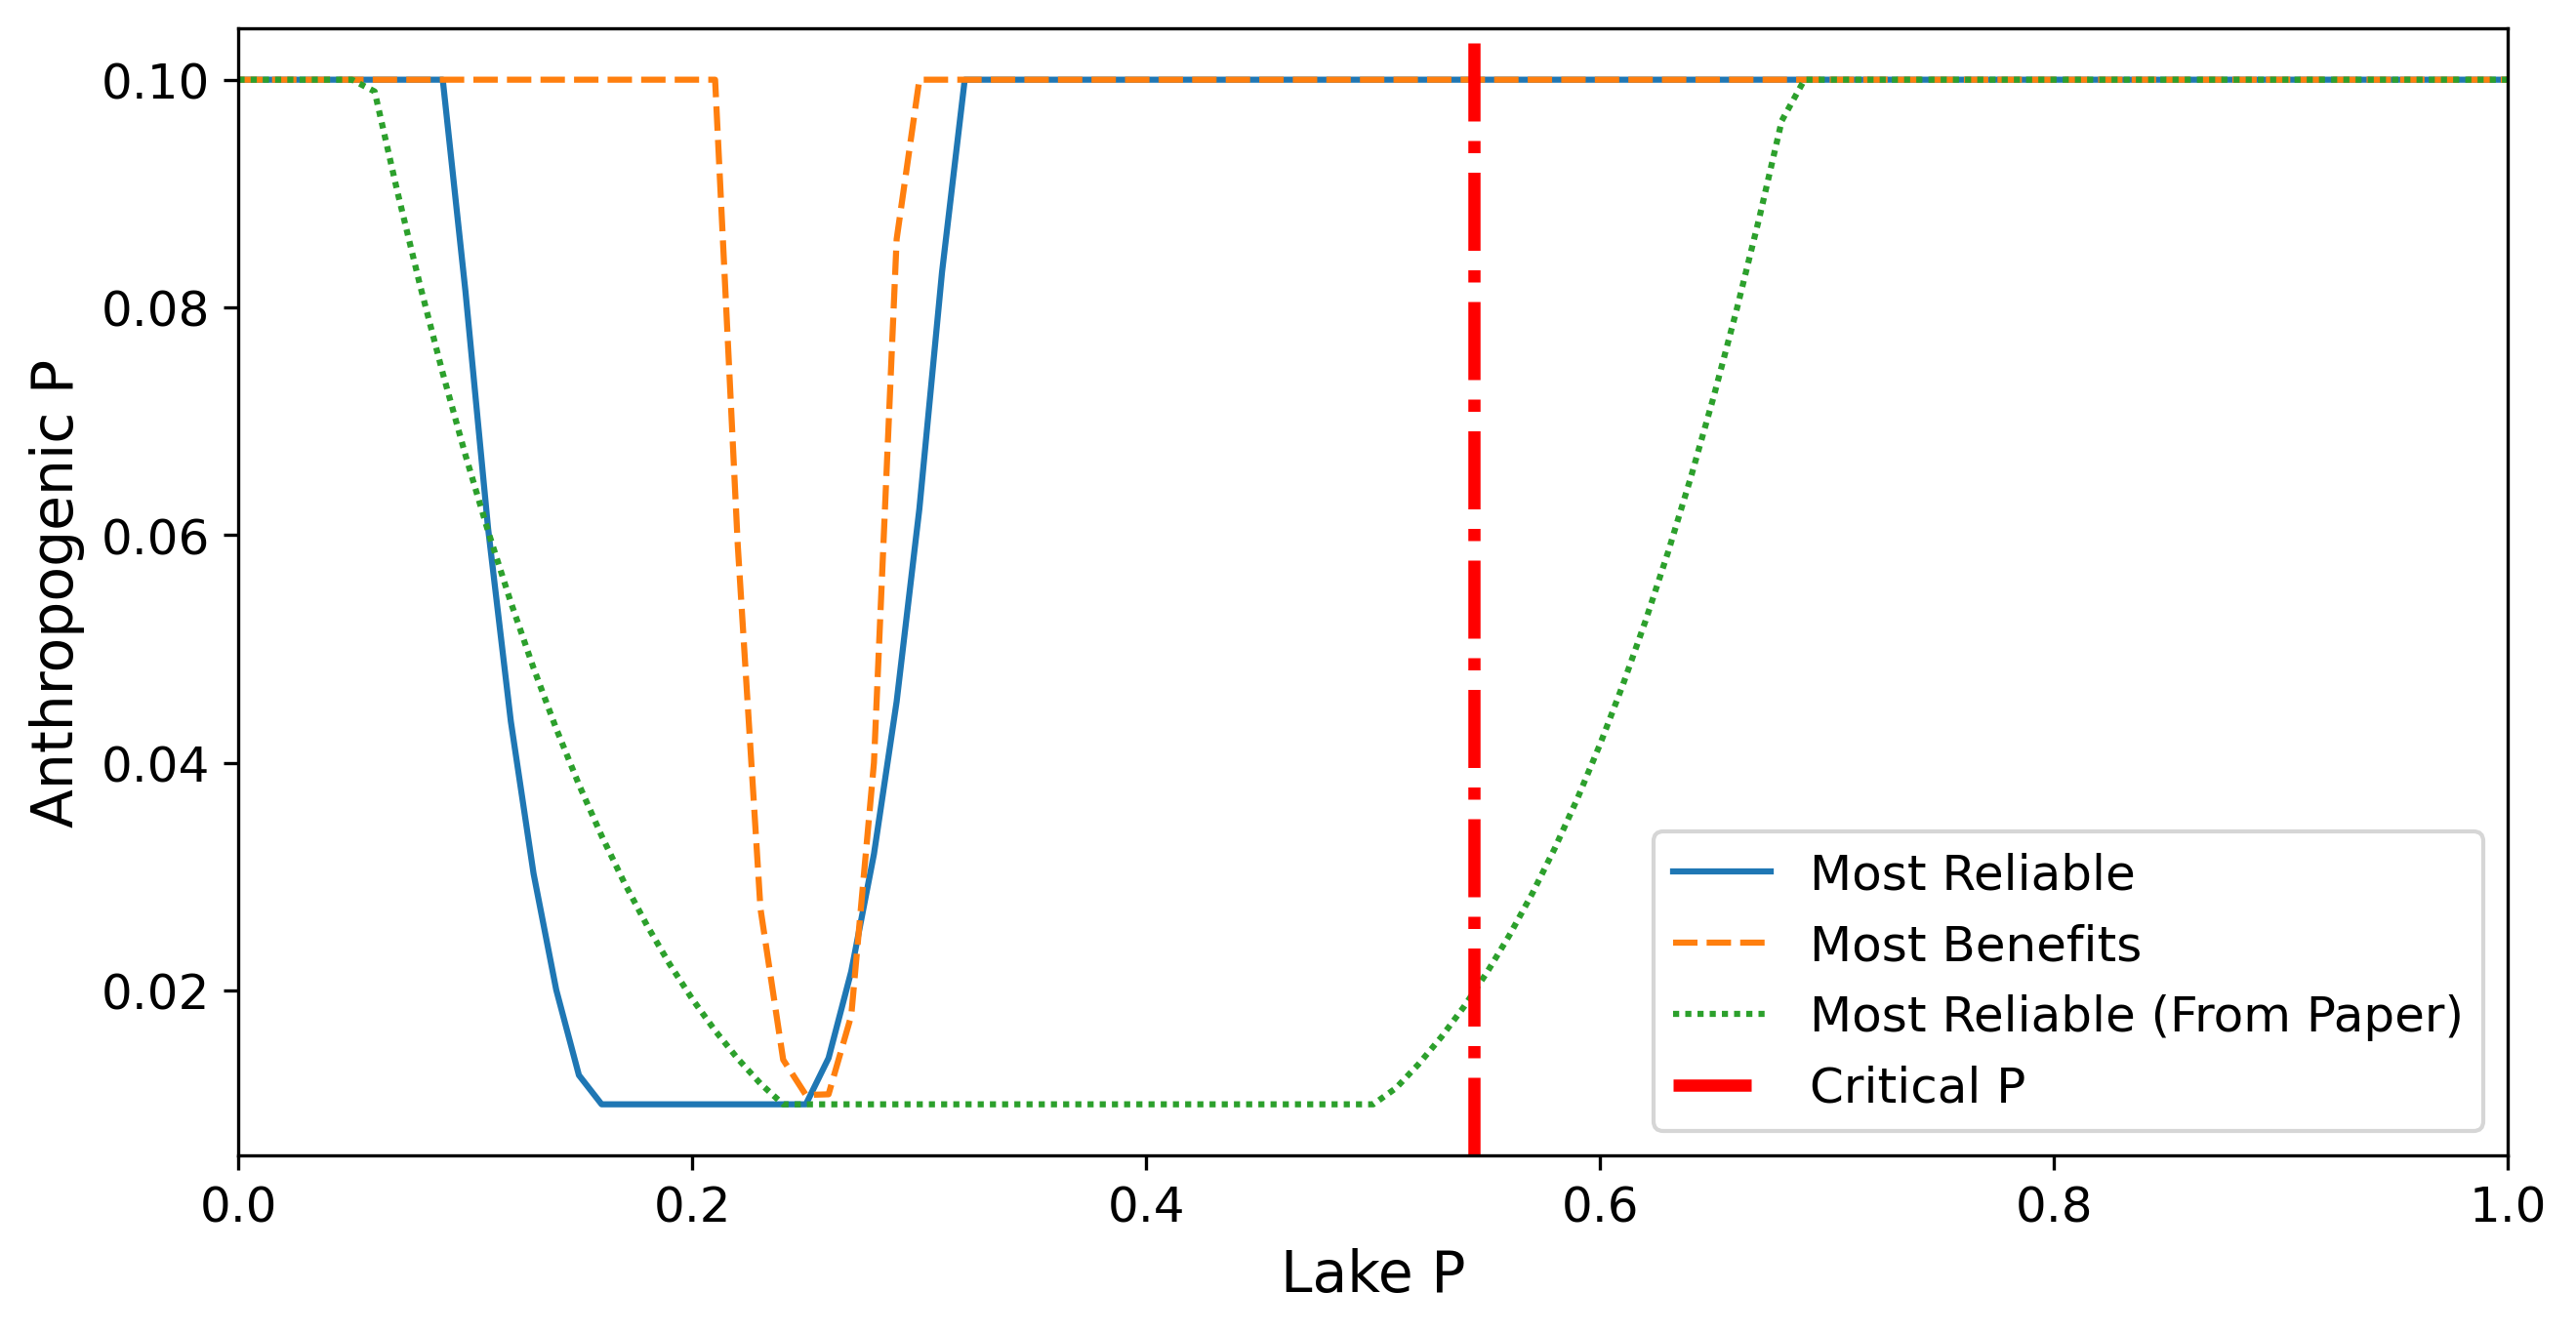

In [4]:
import seaborn as sns
import pandas as pd

# Getting the actions from a given DPS parameterization
def DPSpolicy(lake_state, vars):
    # Determine centers, radii and weights of RBFs
    C = vars[0::3]
    B = vars[1::3]
    W = vars[2::3]
    newW = np.zeros(len(W))
    
    # Normalize weights to sum to 1
    total = sum(W)
    if total != 0.0:
        for i in range(len(W)):
            newW[i] = W[i]/total
    else:
        for i in range(len(W)):
            newW[i] = 1/n
    
    # Determine pollution emission decision, Y
    Y = 0
    for i in range(len(C)):
        if B[i] != 0:
            Y = Y + W[i]*((np.absolute(lake_state-C[i])/B[i])**3)
            
    Y = min(0.1,max(Y,0.01))
    
    return Y

# Load the intertemporal results

# The rows are different strategies
# The first 100 columns are the actions
# The remaining columns are objective values, calculated
# as expected values over the simulated natural inflows
# The last column is the reliability objective
DPS = np.loadtxt('./data/DPS/DPS.resultfile')

# The best reliability strategy minimizes the percentage of
# simulations within a SOW where we pass critical P
# There are only 6 decision variables so the 
# reliability objective is in the 10th column (index 9)
DPSmostRel = np.argmin(DPS[:,9]) 
# The best benefits strategy maximizes net present value
DPSmostBen = np.argmin(DPS[:,6])

# Get the policy curves from the solutions
lake_states = np.arange(0, 2.5, 0.01)

rbf_list = []
for pol, var in zip(['Most Reliable', 'Most Benefits', 'Most Reliable (From Paper)'], [DPSmostRel, DPSmostBen, 26]):
    rbf = pd.DataFrame()
    rbf['Lake P'] = pd.Series(lake_states)
    rbf['Anthropogenic P'] = rbf['Lake P'].apply(lambda x: DPSpolicy(x, DPS[var, 0:6]))
    rbf['Strategy'] = pol
    rbf_list.append(rbf)

rbfs = pd.concat(rbf_list, axis=0)

fig, ax = plt.subplots(figsize=(10, 5),
                       dpi=300)

sns.lineplot(data=rbfs, x='Lake P', y='Anthropogenic P', hue='Strategy', style='Strategy', ax=ax)
ax.set_xlim([0, 1])

ax.axvline(p_crit, color='red', ls='-.', lw=3, label='Critical P')

ax.legend(fontsize='large', loc='lower right')
ax.tick_params('both', labelsize=12)
ax.set_ylabel('Anthropogenic P', size=14)
ax.set_xlabel('Lake P', size=14)

It turns out that many Pareto optimal strategies achieve the best
reliability possible. We will consider an arbitrary strategy with the
best reliability possible (blue) and the one used in the paper (green)
for teaching purposes.

Let’s see what Lake P we take actions on based on a single stochastic
realization of natural inflows with these various control policies. You
can run this code with different seeds to see different results.

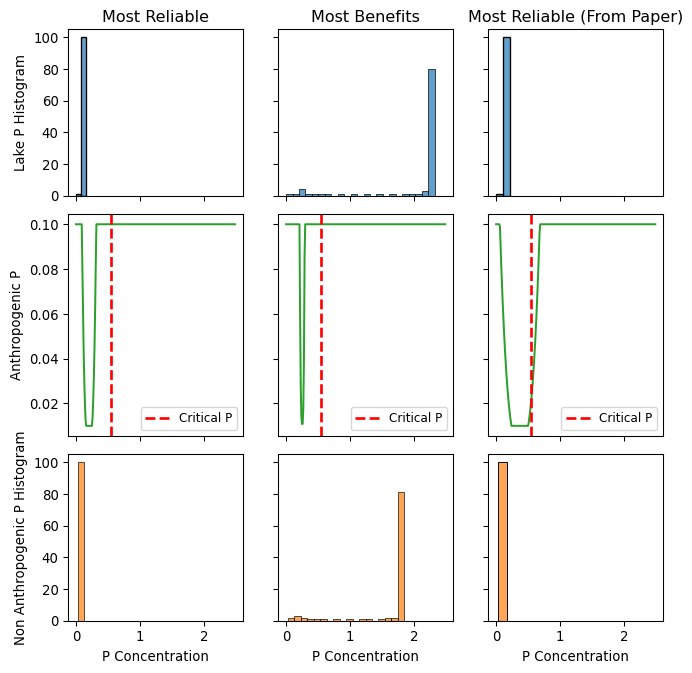

In [5]:
def LakeModel_DPS_adapted(seed, vars):
    log_std = np.sqrt(np.log(1 + sigma**2 / mu**2))
    log_mu = np.log(mu) - 0.5*(log_std**2)
    
    lake_state = np.zeros([nYears + 1])
    np.random.seed(seed)
    natFlow = np.exp(ss.norm.rvs(log_mu, log_std, nYears))
    
    recycling = np.zeros(nYears)  # Store recycling term at each step
    loss = np.zeros(nYears)       # Store loss term (B * X_t) at each step
    
    lake_state[0] = lake0
    Y = np.zeros(nYears)
    Y[0] = DPSpolicy(lake_state[0], vars)
    
    for i in range(nYears):
        recycling[i] = (lake_state[i]**q) / (1 + (lake_state[i]**q))
        loss[i] = lake_state[i] * b  # assuming 'b' is the retention/loss factor
        lake_state[i + 1] = lake_state[i] * (1 - b) + recycling[i] + Y[i] + natFlow[i]
        if i < nYears - 1:
            Y[i + 1] = DPSpolicy(lake_state[i + 1], vars)
    
    # Return lake_state, natural inflows, emissions, recycling, and loss arrays
    return lake_state, natFlow, Y, recycling, loss

seed = 100

lake_state_rel, natFlow_rel, Y_rel, recycling_rel, loss_rel = LakeModel_DPS_adapted(seed, DPS[DPSmostRel, 0:6])
lake_state_ben, natFlow_ben, Y_ben, recycling_ben, loss_ben = LakeModel_DPS_adapted(seed, DPS[DPSmostBen, 0:6])
lake_state_paper, natFlow_paper, Y_paper, recycling_paper, loss_paper = LakeModel_DPS_adapted(seed, DPS[26, 0:6])

policies = ['Most Reliable', 'Most Benefits', 'Most Reliable (From Paper)']
nat_flows = [natFlow_rel, natFlow_ben, natFlow_paper]
rec_flows = [recycling_rel, recycling_ben, recycling_paper]
loss_flows = [loss_rel, loss_ben, loss_paper]
emissions = [Y_rel, Y_ben, Y_paper]
lake_states_list = [lake_state_rel, lake_state_ben, lake_state_paper]

# Create figure with 3 columns and 3 rows: histograms above & below, curves in middle
height_ratios = [0.75, 1, 0.75]  # lake P hist, policy curve, natural inflows hist

fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex='col', sharey='row',
                         gridspec_kw={'height_ratios': height_ratios, 'hspace': 0.1})

policies = ['Most Reliable', 'Most Benefits', 'Most Reliable (From Paper)']

# Top row: Lake P histograms (less tall)
for i, ax in enumerate(axes[0]):
    sns.histplot(lake_states_list[i], binwidth=.1, color='tab:blue', alpha=0.7, ax=ax)
    ax.set_title(f"{policies[i]}", fontsize=12)
    ax.set_ylabel('Lake P Histogram')
    ax.tick_params(axis='x', labelbottom=False)  # hide x labels on top row
    if i > 0:
        ax.set_ylabel('')

# Middle row: Control policy curves (taller)
for i, ax in enumerate(axes[1]):
    df = rbf_list[i]
    sns.lineplot(data=df, x='Lake P', y='Anthropogenic P', color='tab:green', ax=ax)
    ax.axvline(p_crit, color='red', linestyle='--', lw=2, label='Critical P')
    ax.set_ylabel('Anthropogenic P')
    ax.tick_params(axis='x', labelbottom=False)
    ax.legend(fontsize=9, loc='lower right')
    if i > 0:
        ax.set_ylabel('')

# Bottom row: Natural inflows histograms (less tall)
for i, ax in enumerate(axes[2]):
    sns.histplot(nat_flows[i] + rec_flows[i] + loss_flows[i], binwidth=.1, color='tab:orange', alpha=0.7, ax=ax)
    ax.set_xlabel('P Concentration')
    ax.set_ylabel('Non Anthropogenic P Histogram')
    if i > 0:
        ax.set_ylabel('')
    
plt.show()

I intentionally chose a seed that leads to very high concentrations for
the most benefits strategy. Check out a few other seeds. What seeds did
you choose and do they produce the same patterns for each strategy?

Here’s an example with a different seed:

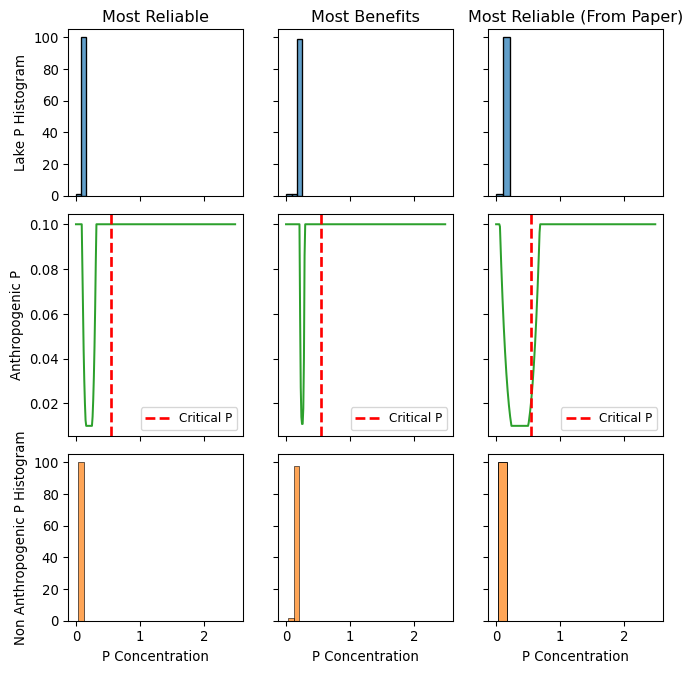

In [6]:
seed = 42

lake_state_rel, natFlow_rel, Y_rel, recycling_rel, loss_rel = LakeModel_DPS_adapted(seed, DPS[DPSmostRel, 0:6])
lake_state_ben, natFlow_ben, Y_ben, recycling_ben, loss_ben = LakeModel_DPS_adapted(seed, DPS[DPSmostBen, 0:6])
lake_state_paper, natFlow_paper, Y_paper, recycling_paper, loss_paper = LakeModel_DPS_adapted(seed, DPS[26, 0:6])

policies = ['Most Reliable', 'Most Benefits', 'Most Reliable (From Paper)']
nat_flows = [natFlow_rel, natFlow_ben, natFlow_paper]
rec_flows = [recycling_rel, recycling_ben, recycling_paper]
loss_flows = [loss_rel, loss_ben, loss_paper]
emissions = [Y_rel, Y_ben, Y_paper]
lake_states_list = [lake_state_rel, lake_state_ben, lake_state_paper]

# Create figure with 3 columns and 3 rows: histograms above & below, curves in middle
height_ratios = [0.75, 1, 0.75]  # lake P hist, policy curve, natural inflows hist

fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex='col', sharey='row',
                         gridspec_kw={'height_ratios': height_ratios, 'hspace': 0.1})

policies = ['Most Reliable', 'Most Benefits', 'Most Reliable (From Paper)']

# Top row: Lake P histograms (less tall)
for i, ax in enumerate(axes[0]):
    sns.histplot(lake_states_list[i], binwidth=.1, color='tab:blue', alpha=0.7, ax=ax)
    ax.set_title(f"{policies[i]}", fontsize=12)
    ax.set_ylabel('Lake P Histogram')
    ax.tick_params(axis='x', labelbottom=False)  # hide x labels on top row
    if i > 0:
        ax.set_ylabel('')

# Middle row: Control policy curves (taller)
for i, ax in enumerate(axes[1]):
    df = rbf_list[i]
    sns.lineplot(data=df, x='Lake P', y='Anthropogenic P', color='tab:green', ax=ax)
    ax.axvline(p_crit, color='red', linestyle='--', lw=2, label='Critical P')
    ax.set_ylabel('Anthropogenic P')
    ax.tick_params(axis='x', labelbottom=False)
    ax.legend(fontsize=9, loc='lower right')
    if i > 0:
        ax.set_ylabel('')

# Bottom row: Natural inflows histograms (less tall)
for i, ax in enumerate(axes[2]):
    sns.histplot(nat_flows[i] + rec_flows[i] + loss_flows[i], binwidth=.1, color='tab:orange', alpha=0.7, ax=ax)
    ax.set_xlabel('P Concentration')
    ax.set_ylabel('Non Anthropogenic P Histogram')
    if i > 0:
        ax.set_ylabel('')
    
plt.show()

What do you see about the distribution of all observed P concentrations
across the realizations you evaluated of both naturally (inflows,
recycling, loss summed on bottom row) and including the anthropogenic P
concentration (top row)?

Now, let’s look across many stochastic realizations.

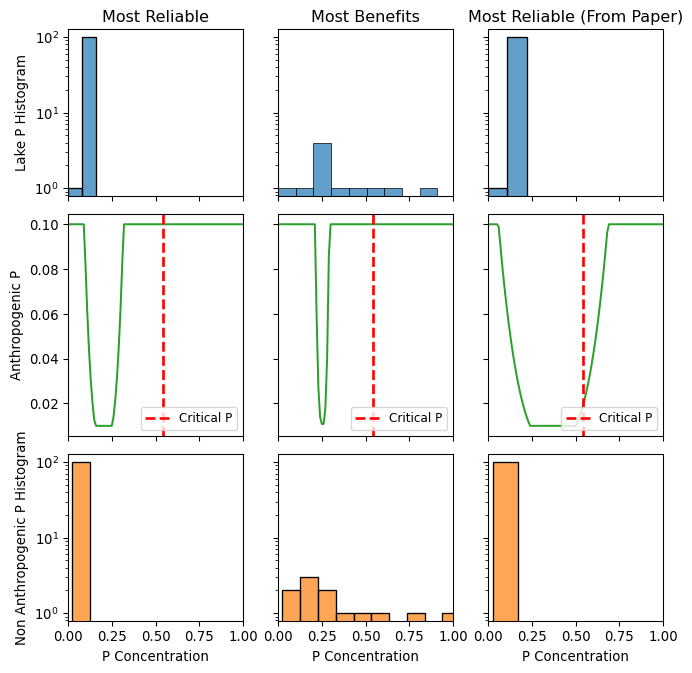

In [7]:
seed = 100

lake_state_rel, natFlow_rel, Y_rel, recycling_rel, loss_rel = LakeModel_DPS_adapted(seed, DPS[DPSmostRel, 0:6])
lake_state_ben, natFlow_ben, Y_ben, recycling_ben, loss_ben = LakeModel_DPS_adapted(seed, DPS[DPSmostBen, 0:6])
lake_state_paper, natFlow_paper, Y_paper, recycling_paper, loss_paper = LakeModel_DPS_adapted(seed, DPS[26, 0:6])

policies = ['Most Reliable', 'Most Benefits', 'Most Reliable (From Paper)']
nat_flows = [natFlow_rel, natFlow_ben, natFlow_paper]
rec_flows = [recycling_rel, recycling_ben, recycling_paper]
loss_flows = [loss_rel, loss_ben, loss_paper]
emissions = [Y_rel, Y_ben, Y_paper]
lake_states_list = [lake_state_rel, lake_state_ben, lake_state_paper]

# Create figure with 3 columns and 3 rows: histograms above & below, curves in middle
height_ratios = [0.75, 1, 0.75]  # lake P hist, policy curve, natural inflows hist

fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex='col', sharey='row',
                         gridspec_kw={'height_ratios': height_ratios, 'hspace': 0.1})

policies = ['Most Reliable', 'Most Benefits', 'Most Reliable (From Paper)']

# Top row: Lake P histograms (over all runs) - log scale y-axis
for i, ax in enumerate(axes[0]):
    sns.histplot(lake_states_list[i], binwidth=.1, color='tab:blue', alpha=0.7, ax=ax)
    ax.set_yscale('log') 
    ax.set_title(f"{policies[i]}", fontsize=12)
    ax.set_ylabel('Lake P Histogram')
    ax.set_xlim([0, 1])
    ax.tick_params(axis='x', labelbottom=False)
    if i > 0:
        ax.set_ylabel('')

# Middle row: Control policy curves (taller)
for i, ax in enumerate(axes[1]):
    df = rbf_list[i]
    sns.lineplot(data=df, x='Lake P', y='Anthropogenic P', color='tab:green', ax=ax)
    ax.axvline(p_crit, color='red', linestyle='--', lw=2, label='Critical P')
    ax.set_ylabel('Anthropogenic P')
    ax.tick_params(axis='x', labelbottom=False)
    ax.legend(fontsize=9, loc='lower right')
    if i > 0:
        ax.set_ylabel('')

# Bottom row: Natural inflows histograms (less tall)
for i, ax in enumerate(axes[2]):
    combined = nat_flows[i] + rec_flows[i] + loss_flows[i]
    sns.histplot(combined, binwidth=.1, color='tab:orange', alpha=0.7, ax=ax)
    ax.set_yscale('log')
    ax.set_xlabel('P Concentration')
    ax.set_ylabel('Non Anthropogenic P Histogram')
    ax.set_xlim([0, 1])
    if i > 0:
        ax.set_ylabel('')
    
plt.show()

What do you see about the distribution of all observed P concentrations
across all the realizations of both naturally (inflows, recycling, loss
summed on bottom row) and including the anthropogenic P concentration
(top row)?

Let’s take a look at these P concentrations across all of these states.
Each realization can have a different anthropogenic P sequence, so we’re
not going to plot exactly the same way we did for the intertemporal.

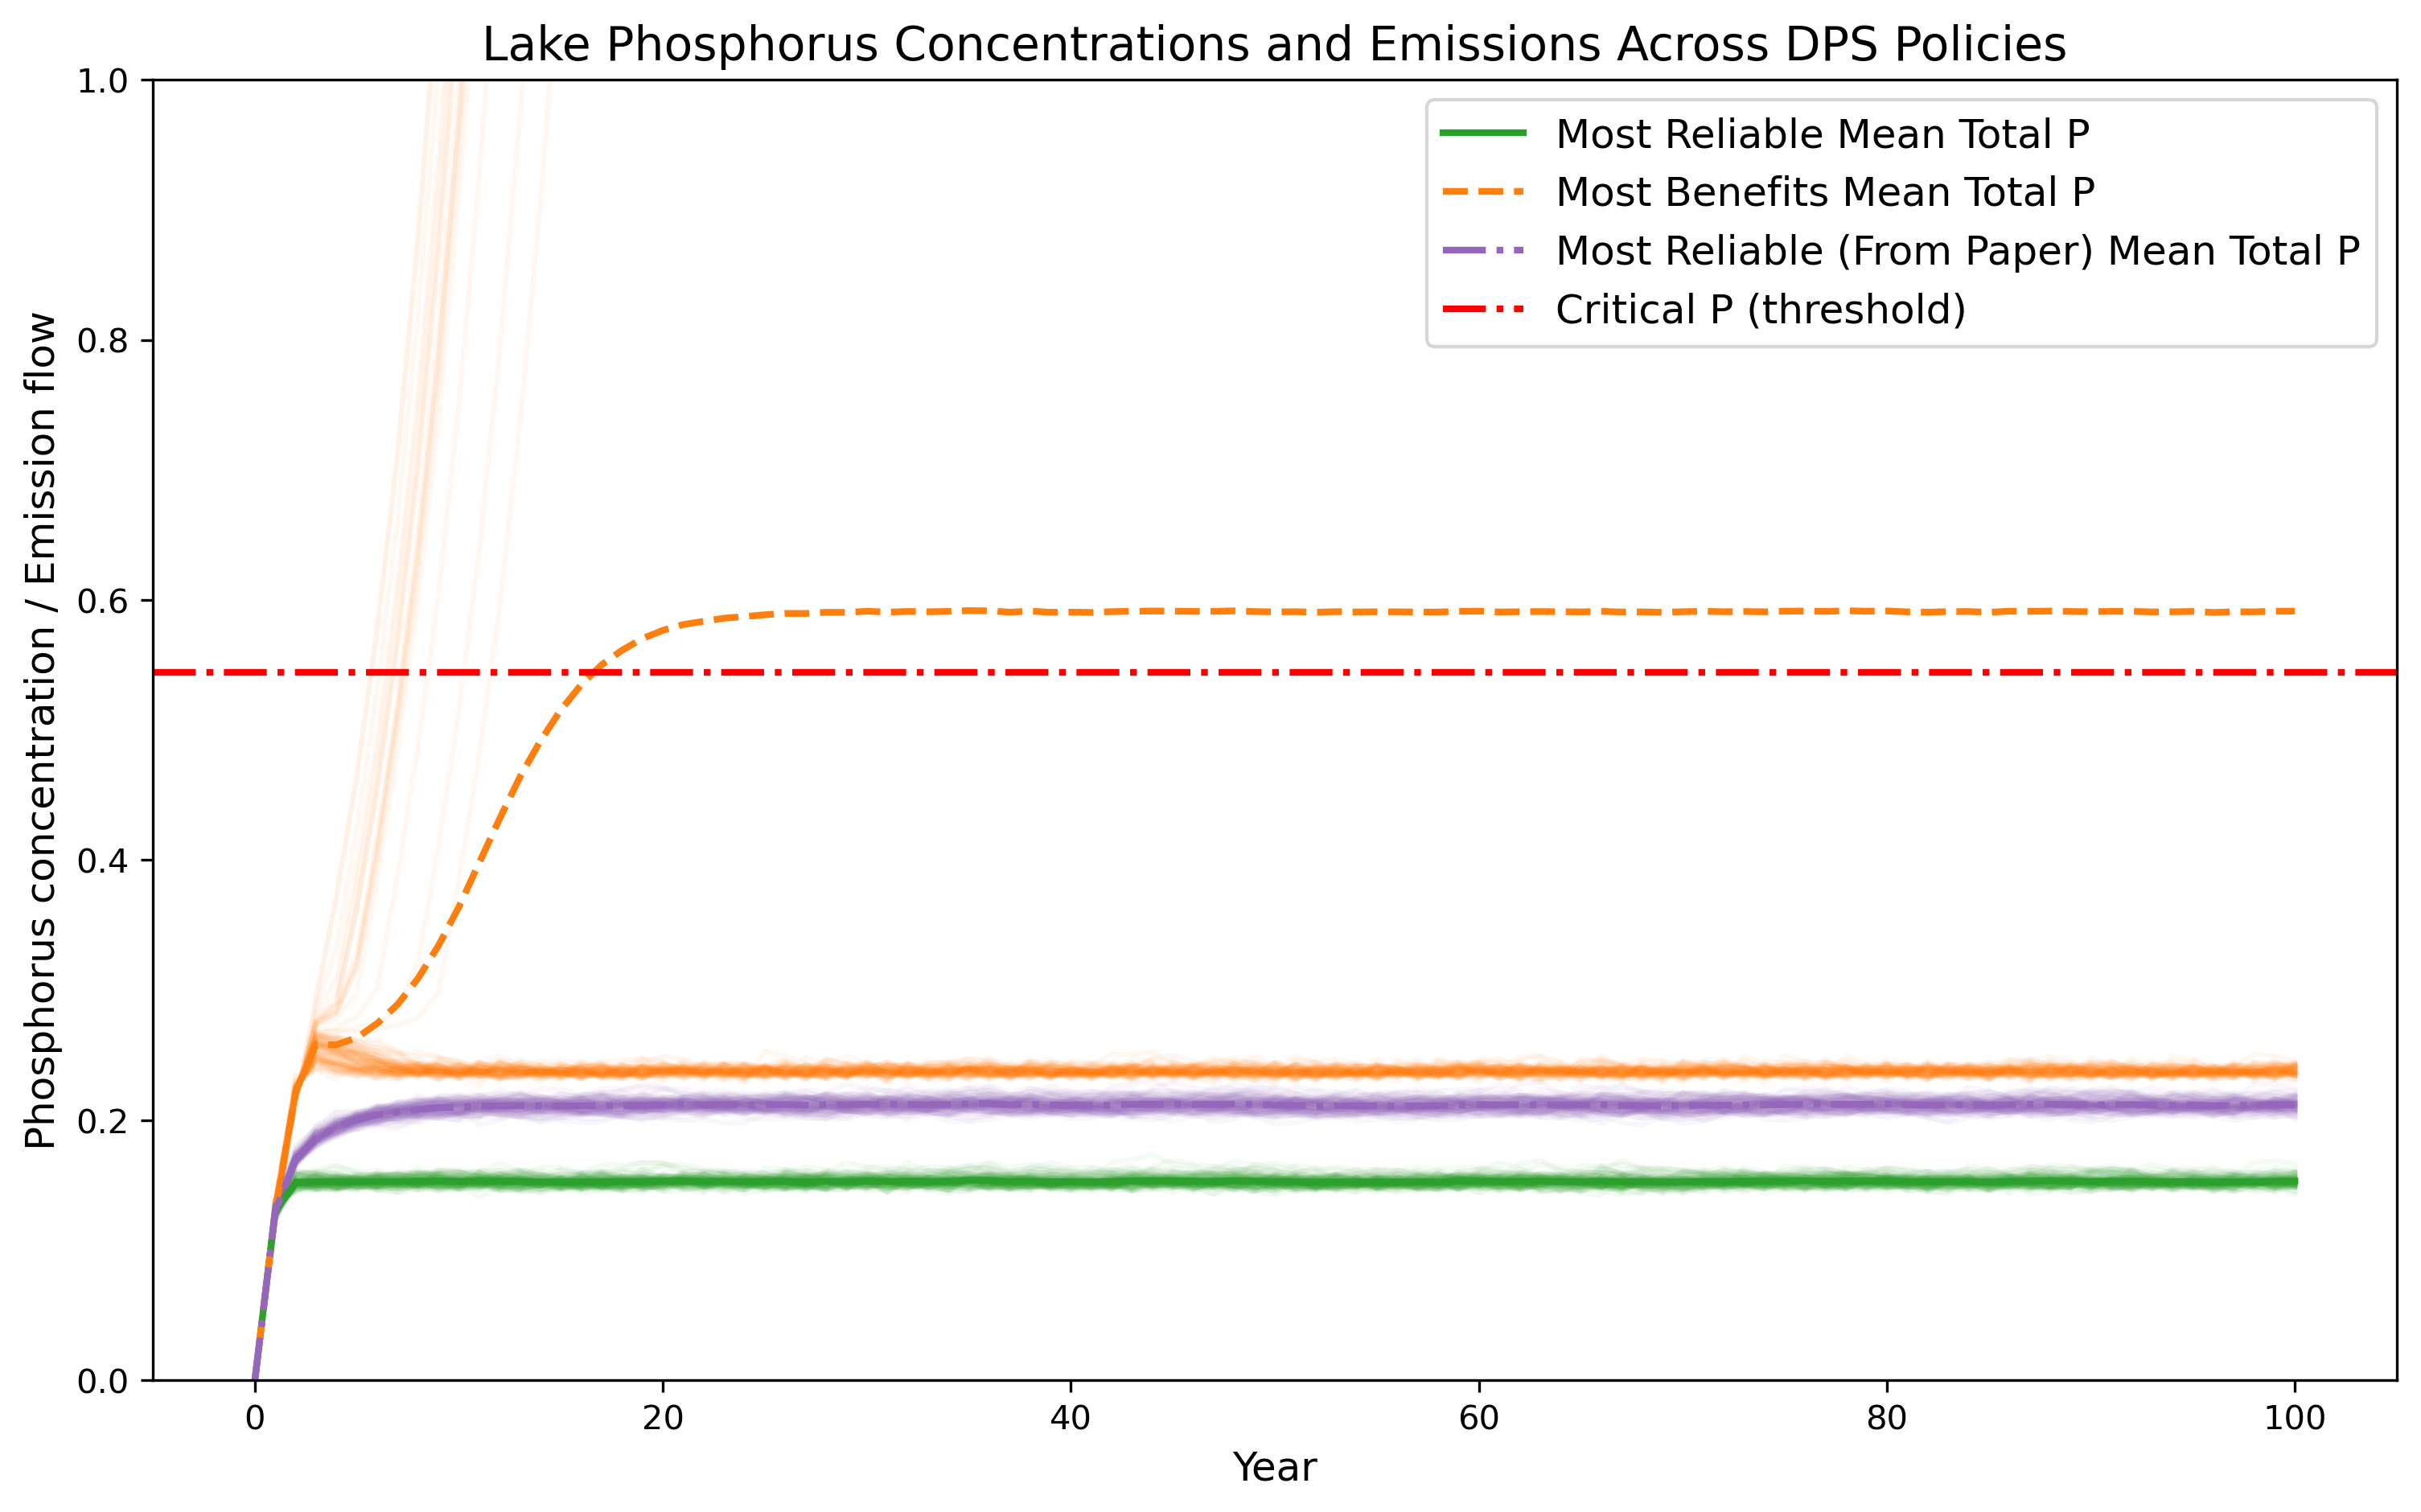

In [8]:
policy_names = ['Most Reliable', 'Most Benefits', 'Most Reliable (From Paper)']
policy_indices = [DPSmostRel, DPSmostBen, 26]

# Preallocate storage for states for all simulations and policies
nSamples = 100  # your number of Monte Carlo simulations
nYears = 100    # length of simulation
years = np.arange(nYears + 1)

totalP_all = {name: [] for name in policy_names}
anthP_all = {name: [] for name in policy_names}
natP_all = {name: [] for name in policy_names}
recP_all = {name: [] for name in policy_names}
lossP_all = {name: [] for name in policy_names}

# Run all simulations for each policy
for sim in range(nSamples):
    for name, idx in zip(policy_names, policy_indices):
        lake_state, natFlow, actions, recs, losses = LakeModel_DPS_adapted(sim + 1000, DPS[idx, 0:6])
        # collect total phosphorus time series (index 0 of returned tuple)
        totalP_all[name].append(lake_state)
        # collect anthro P time series
        anthP_all[name].append(actions)
        # collect the rest
        natP_all[name].append(natFlow)
        recP_all[name].append(recs)
        lossP_all[name].append(losses)

# Plotting setup
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

colors = {'Most Reliable': 'tab:green',
          'Most Benefits': 'tab:orange',
          'Most Reliable (From Paper)': 'tab:purple'}

linestyles = {'Most Reliable': '-',
              'Most Benefits': '--',
              'Most Reliable (From Paper)': '-.'}

# Plot individual simulation total P flows with very low alpha
for name in policy_names:
    for run in totalP_all[name]:
        ax.plot(years, run, color=colors[name], alpha=0.05)

# Plot mean total P time series for each policy
for name in policy_names:
    mean_totalP = np.mean(totalP_all[name], axis=0)
    ax.plot(years, mean_totalP, color=colors[name], lw=2, linestyle=linestyles[name], label=f'{name} Mean Total P')

# Plot critical phosphorus concentration line
ax.axhline(p_crit, color='red', linestyle='-.', lw=2, label='Critical P (threshold)')

# Labels and limits
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Phosphorus concentration / Emission flow', fontsize=12)
ax.set_ylim([0, 1])

# Construct a clear custom legend
legend_elements = [
    Line2D([0], [0], color=colors['Most Reliable'], lw=2, ls=linestyles['Most Reliable'], label='Most Reliable Mean Total P'),
    Line2D([0], [0], color=colors['Most Benefits'], lw=2, ls=linestyles['Most Benefits'], label='Most Benefits Mean Total P'),
    Line2D([0], [0], color=colors['Most Reliable (From Paper)'], lw=2, ls=linestyles['Most Reliable (From Paper)'], label='Most Reliable (From Paper) Mean Total P'),
    Line2D([0], [0], color='red', lw=2, ls='-.', label='Critical P (threshold)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize='large')

plt.title('Lake Phosphorus Concentrations and Emissions Across DPS Policies', fontsize=14)
plt.show()

How would you characterize the behavior of the different strategies? Is
the mean P a good way to characterize the strategies’ dynamics?

Let’s take a closer look at those realizations where the max benefit
policy leads to eutrophication.

/var/folders/d2/g0h08s551zb2hz_ws2g4ggh400hbd0/T/ipykernel_79786/1823386331.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

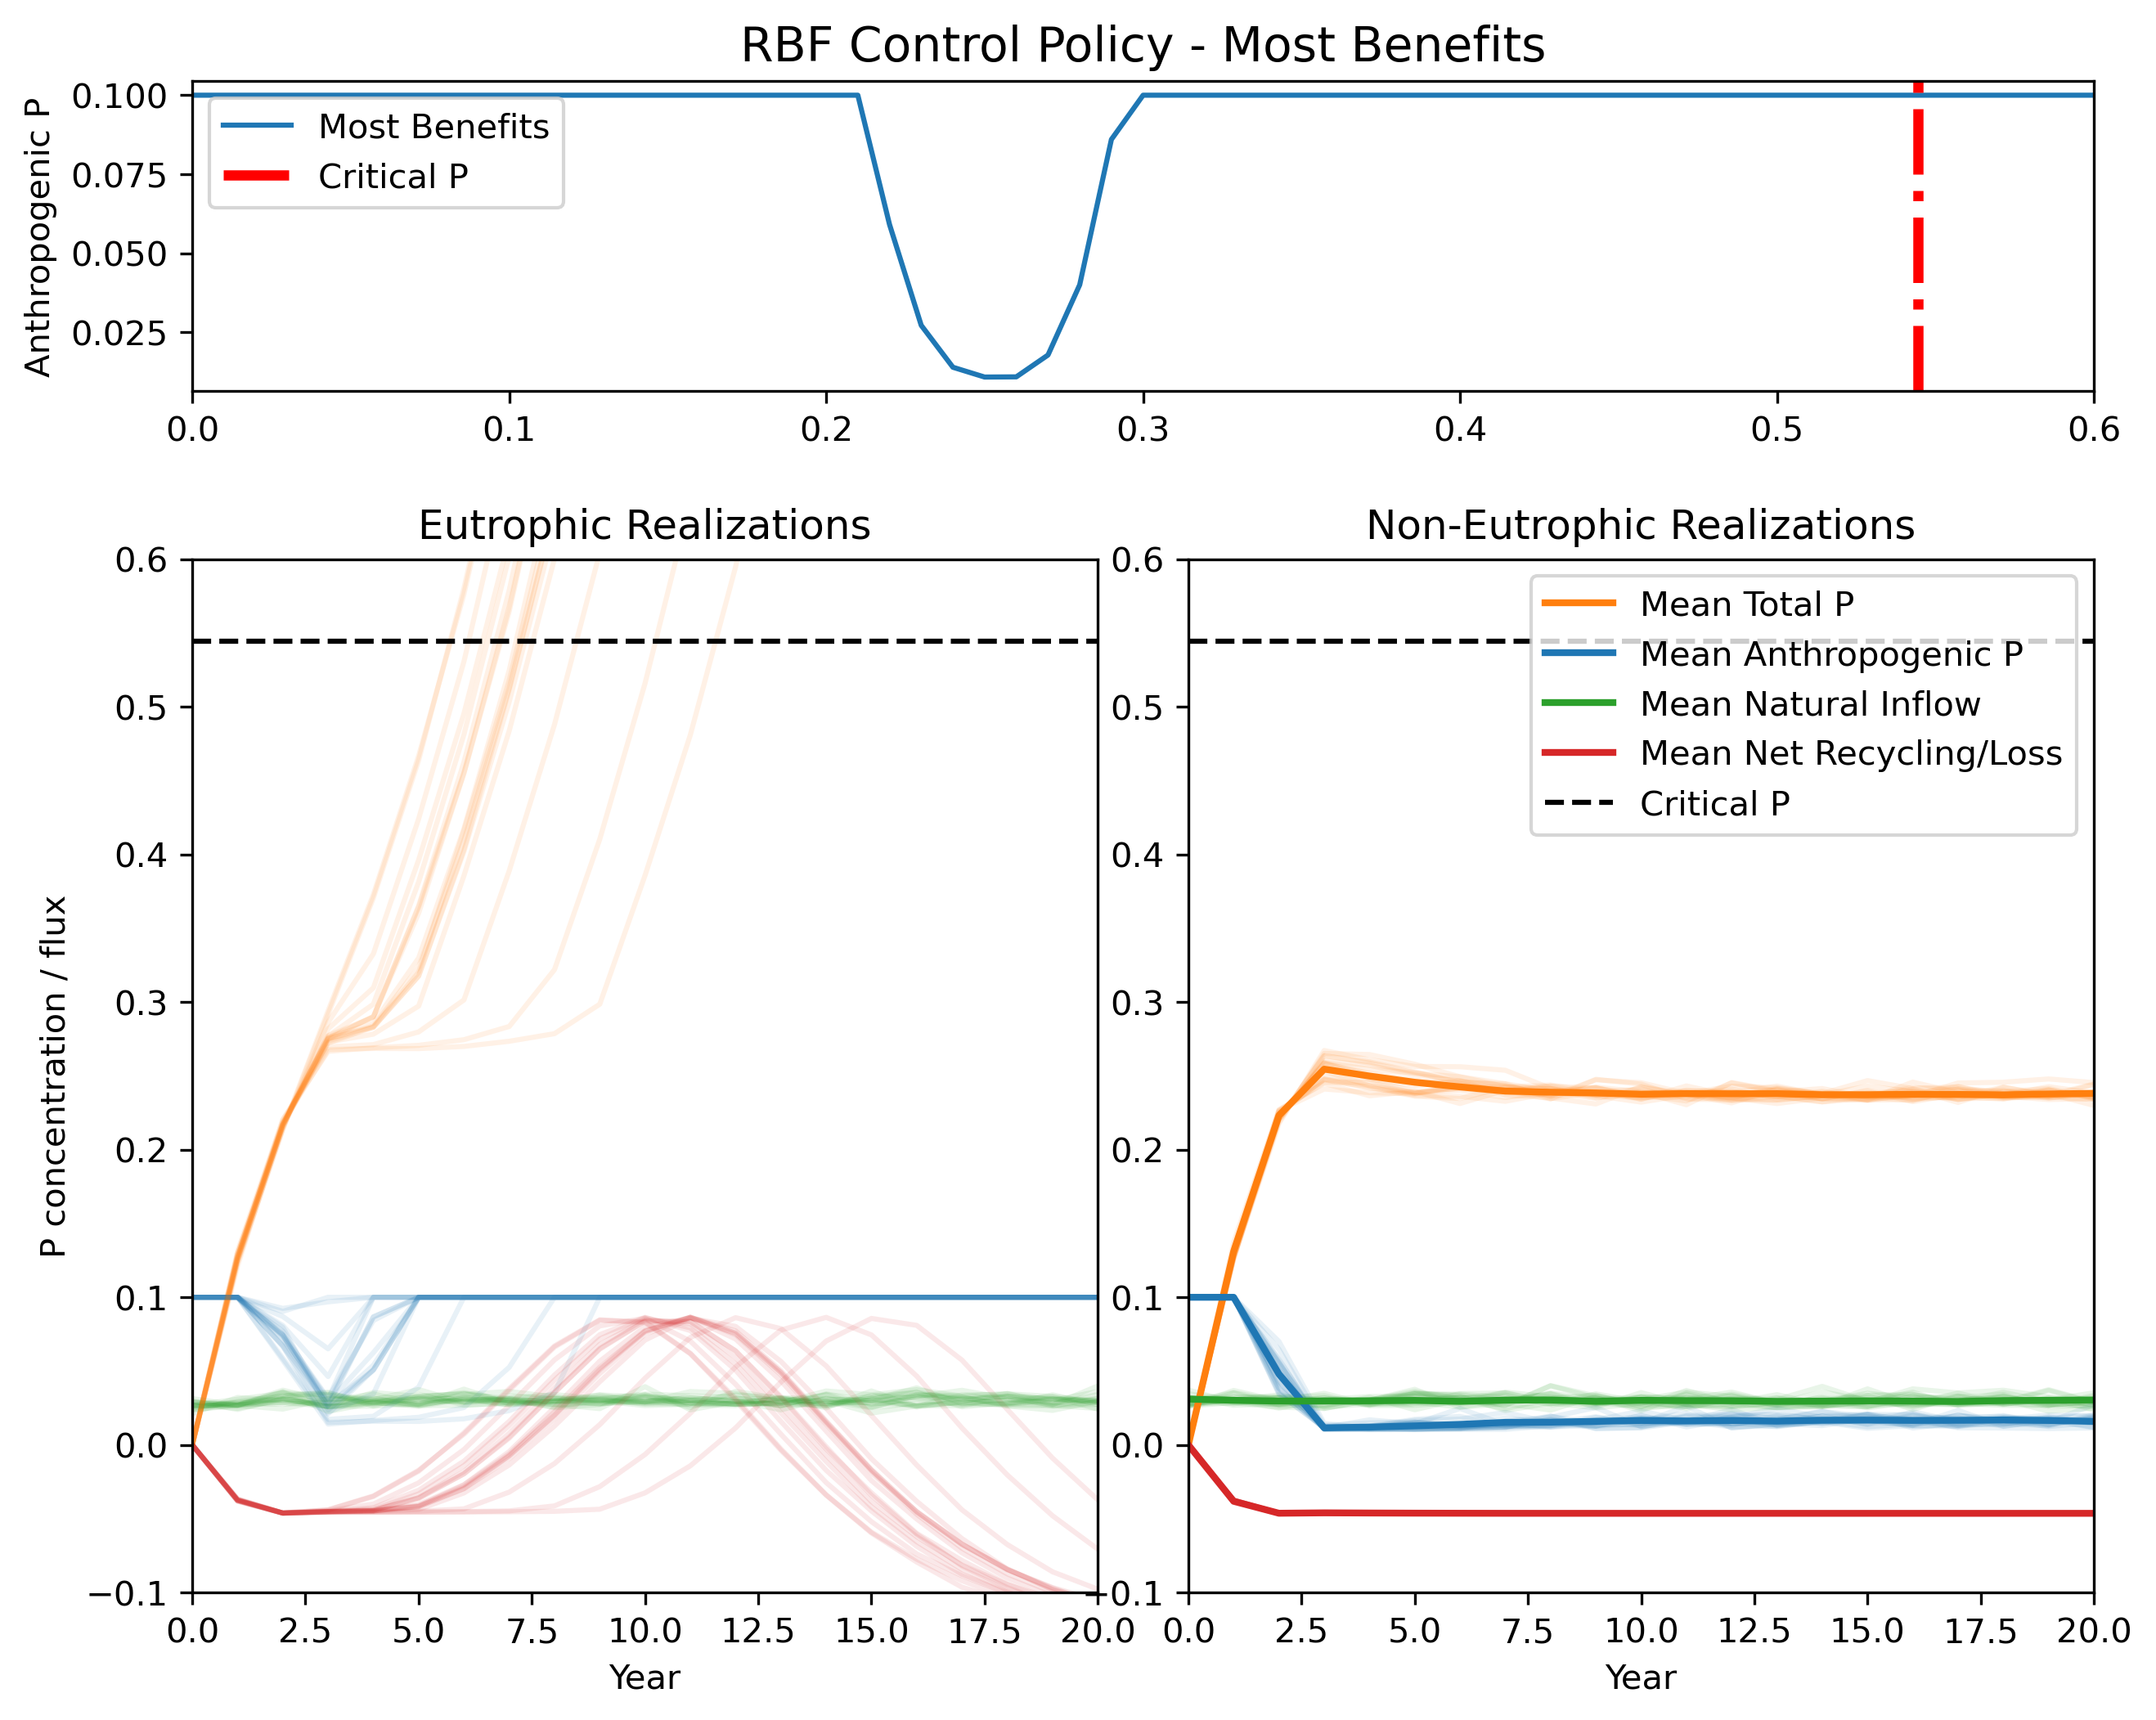

In [9]:
from matplotlib.gridspec import GridSpec

temp = pd.DataFrame(totalP_all['Most Benefits'])
# Runs that exceed critical P
eutrophic_runs_idx = temp[(temp > p_crit).sum(axis=1) > 0].index
non_eutrophic_runs_idx = temp[(temp > p_crit).sum(axis=1) == 0].index

# Extract the eutrophic realizations data
totalP_eutrophic = [totalP_all['Most Benefits'][i] for i in eutrophic_runs_idx]
anthP_eutrophic = [anthP_all['Most Benefits'][i] for i in eutrophic_runs_idx]
natFlow_eutrophic = [natP_all['Most Benefits'][i] for i in eutrophic_runs_idx]
recycling_eutrophic = [recP_all['Most Benefits'][i] for i in eutrophic_runs_idx]
loss_eutrophic = [lossP_all['Most Benefits'][i] for i in eutrophic_runs_idx]

# And non eutrophic
totalP_non_eutrophic = [totalP_all['Most Benefits'][i] for i in non_eutrophic_runs_idx]
anthP_non_eutrophic = [anthP_all['Most Benefits'][i] for i in non_eutrophic_runs_idx]
natFlow_non_eutrophic = [natP_all['Most Benefits'][i] for i in non_eutrophic_runs_idx]
recycling_non_eutrophic = [recP_all['Most Benefits'][i] for i in non_eutrophic_runs_idx]
loss_non_eutrophic = [lossP_all['Most Benefits'][i] for i in non_eutrophic_runs_idx]

years = np.arange(len(totalP_eutrophic[0]))

# Net recycling/loss:
net_recycling_eutrophic = [r - l for r, l in zip(recycling_eutrophic, loss_eutrophic)]

net_recycling_non_eutrophic = [r - l for r, l in zip(recycling_non_eutrophic, loss_non_eutrophic)]

# Combine and create figure
fig = plt.figure(figsize=(10, 8), dpi=300)
gs = GridSpec(nrows=2, ncols=2, figure=fig, width_ratios=[1, 1], wspace=0.1, hspace=0.25, 
              height_ratios=[.3, 1])

# --- Top panel: RBF control policies ---
ax0 = fig.add_subplot(gs[0, :])
sns.lineplot(data=rbfs[rbfs['Strategy'] == 'Most Benefits'], x='Lake P', y='Anthropogenic P', hue='Strategy', style='Strategy', ax=ax0)
ax0.axvline(p_crit, color='red', linestyle='-.', lw=3, label='Critical P')
ax0.set_title('RBF Control Policy - Most Benefits', size=14)
ax0.set_ylabel('Anthropogenic P')
ax0.set_xlabel('')
ax0.set_xlim([0, .6])
ax0.legend(fontsize='medium')

# --- Bottom panel, Left: Dynamics of eutrophic runs ---
ax10 = fig.add_subplot(gs[1, 0])
for i in range(len(eutrophic_runs_idx)):
    # Plot each realization with low alpha for clarity:
    ax10.plot(years, totalP_eutrophic[i], color='tab:orange', alpha=0.1)
    ax10.plot(years[:-1], anthP_eutrophic[i], color='tab:blue', alpha=0.1)
    ax10.plot(years[:-1], natFlow_eutrophic[i], color='tab:green', alpha=0.1)
    ax10.plot(years[:-1], net_recycling_eutrophic[i], color='tab:red', alpha=0.1)

# Bottom panel, right: dynamics of non eutrophic runs
ax11 = fig.add_subplot(gs[1, 1])
for i in range(len(eutrophic_runs_idx)):
    # Plot each realization with low alpha for clarity:
    ax11.plot(years, totalP_non_eutrophic[i], color='tab:orange', alpha=0.1)
    ax11.plot(years[:-1], anthP_non_eutrophic[i], color='tab:blue',  alpha=0.1)
    ax11.plot(years[:-1], natFlow_non_eutrophic[i], color='tab:green', alpha=0.1)
    ax11.plot(years[:-1], net_recycling_non_eutrophic[i], color='tab:red', alpha=0.1)

ax10.axhline(p_crit, color='black', linestyle='--', label='Critical P')
ax10.set_xlabel('Year')
ax10.set_ylabel('P concentration / flux')
ax10.set_title('Eutrophic Realizations')
ax10.set_xlim(0, 20)
ax10.set_ylim([-.1, .6])

ax11.plot(years, np.mean(totalP_non_eutrophic, axis=0), color='tab:orange', lw=2, label='Mean Total P')
ax11.plot(years[:-1], np.mean(anthP_non_eutrophic, axis=0), color='tab:blue', lw=2, label='Mean Anthropogenic P')
ax11.plot(years[:-1], np.mean(natFlow_non_eutrophic, axis=0), color='tab:green', lw=2, label='Mean Natural Inflow')
ax11.plot(years[:-1], np.mean(net_recycling_non_eutrophic, axis=0), color='tab:red', lw=2, label='Mean Net Recycling/Loss')

ax11.axhline(p_crit, color='black', linestyle='--', label='Critical P')
ax11.set_xlabel('Year')
ax11.set_ylabel('')
ax11.set_title('Non-Eutrophic Realizations')
ax11.legend(fontsize='medium')
ax11.set_xlim(0, 20)
ax11.set_ylim([-.1, .6])

plt.tight_layout()
plt.show()

Can you see what the difference is between the eutrophic and
non-eutrophic realizations? Recall that these are using the exact same
control policies. Let’s try zooming in even more on the early years of
the problem and focus on the total P trajectories, along with our RBF
and where it tells us to emit less. Recall that in our optimization
formulation, we set .01 as our minimum allowable emission.

/var/folders/d2/g0h08s551zb2hz_ws2g4ggh400hbd0/T/ipykernel_79786/1156415406.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

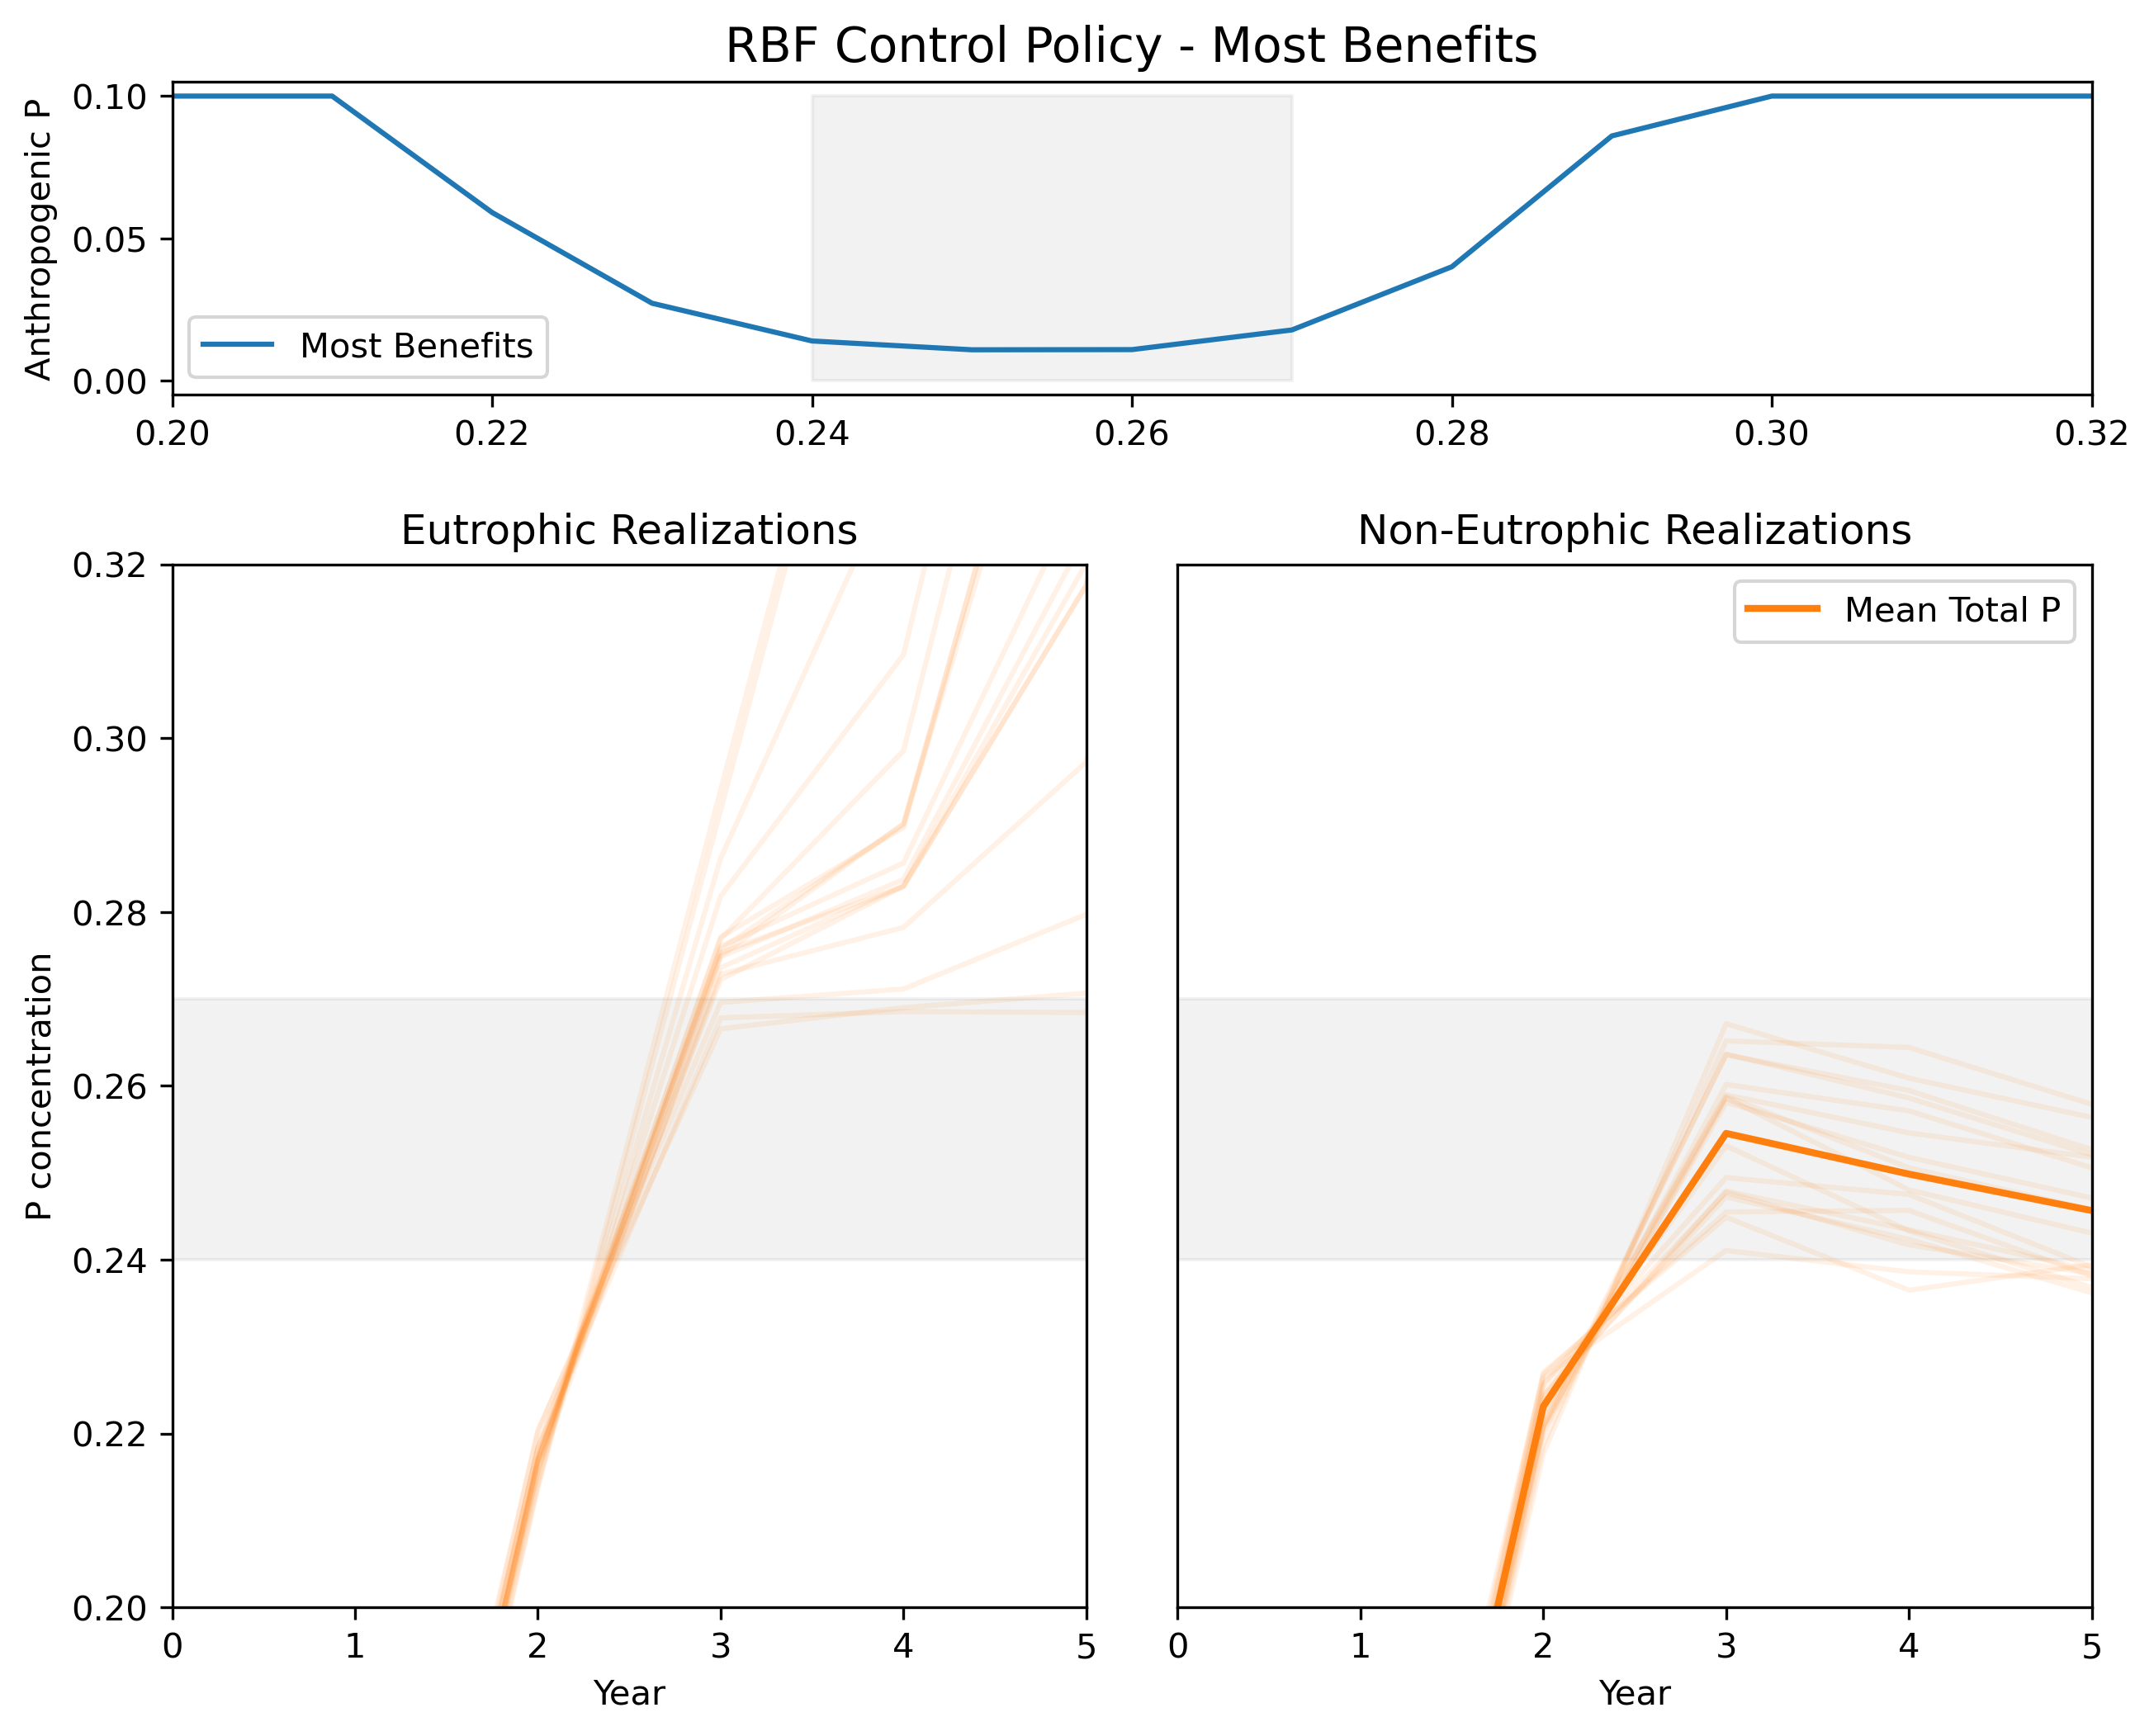

In [10]:
# Combine and create figure
fig = plt.figure(figsize=(10, 8), dpi=300)
gs = GridSpec(nrows=2, ncols=2, figure=fig, width_ratios=[1, 1], wspace=0.1, hspace=0.25, 
              height_ratios=[.3, 1])

# --- Top panel: RBF control policies ---
ax0 = fig.add_subplot(gs[0, :])
sns.lineplot(data=rbfs[rbfs['Strategy'] == 'Most Benefits'], x='Lake P', y='Anthropogenic P', hue='Strategy', style='Strategy', ax=ax0)
ax0.set_title('RBF Control Policy - Most Benefits', size=14)
ax0.set_ylabel('Anthropogenic P')
ax0.set_xlabel('')
ax0.set_xlim([.20, .32])
ax0.legend(fontsize='medium')

# --- Bottom panel, Left: Dynamics of eutrophic runs ---
ax10 = fig.add_subplot(gs[1, 0])
for i in range(len(eutrophic_runs_idx)):
    # Plot each realization with low alpha for clarity:
    ax10.plot(years, totalP_eutrophic[i], color='tab:orange', alpha=0.1)
    ax10.plot(years[:-1], anthP_eutrophic[i], color='tab:blue', alpha=0.1)
    ax10.plot(years[:-1], natFlow_eutrophic[i], color='tab:green', alpha=0.1)
    ax10.plot(years[:-1], net_recycling_eutrophic[i], color='tab:red', alpha=0.1)

# Bottom panel, right: dynamics of non eutrophic runs
ax11 = fig.add_subplot(gs[1, 1])
for i in range(len(eutrophic_runs_idx)):
    # Plot each realization with low alpha for clarity:
    ax11.plot(years, totalP_non_eutrophic[i], color='tab:orange', alpha=0.1)
    ax11.plot(years[:-1], anthP_non_eutrophic[i], color='tab:blue',  alpha=0.1)
    ax11.plot(years[:-1], natFlow_non_eutrophic[i], color='tab:green', alpha=0.1)
    ax11.plot(years[:-1], net_recycling_non_eutrophic[i], color='tab:red', alpha=0.1)

ax10.axhline(p_crit, color='black', linestyle='--', label='Critical P')
ax10.set_xlabel('Year')
ax10.set_ylabel('P concentration')
ax10.set_title('Eutrophic Realizations')
ax10.set_xlim(0, 5)
ax10.set_ylim([.20, .32])

ax11.plot(years, np.mean(totalP_non_eutrophic, axis=0), color='tab:orange', lw=2, label='Mean Total P')

ax11.set_xlabel('Year')
ax11.set_ylabel('')
ax11.set_title('Non-Eutrophic Realizations')
ax11.legend(fontsize='medium')
ax11.set_xlim(0, 5)
ax11.set_ylim([.20, .32])
ax11.tick_params(left=False, labelleft=False)

ax11.fill_between([0, 5], .24, .27, color='gray', alpha=.1)
ax10.fill_between([0, 5], .24, .27, color='gray', alpha=.1)
ax0.fill_between([.24, .27], 0, .1, color='gray', alpha=.1)

plt.tight_layout()
plt.show()

We can roughly highlight a region of P concentration at year 3 where the
eutrophic and non-eutrophic realizations begin to look different from
one another. The non-eutrophic realizations do not cross .27 in year 3,
but many of the eutrophic realizations do.

Let’s revisit our P recycling and loss plot and zoom in on the area
below the threshold. We’ll add a shaded area to indicate the mean
natural P inflow so that we can get a better sense for what P
concentrations are dangerous.

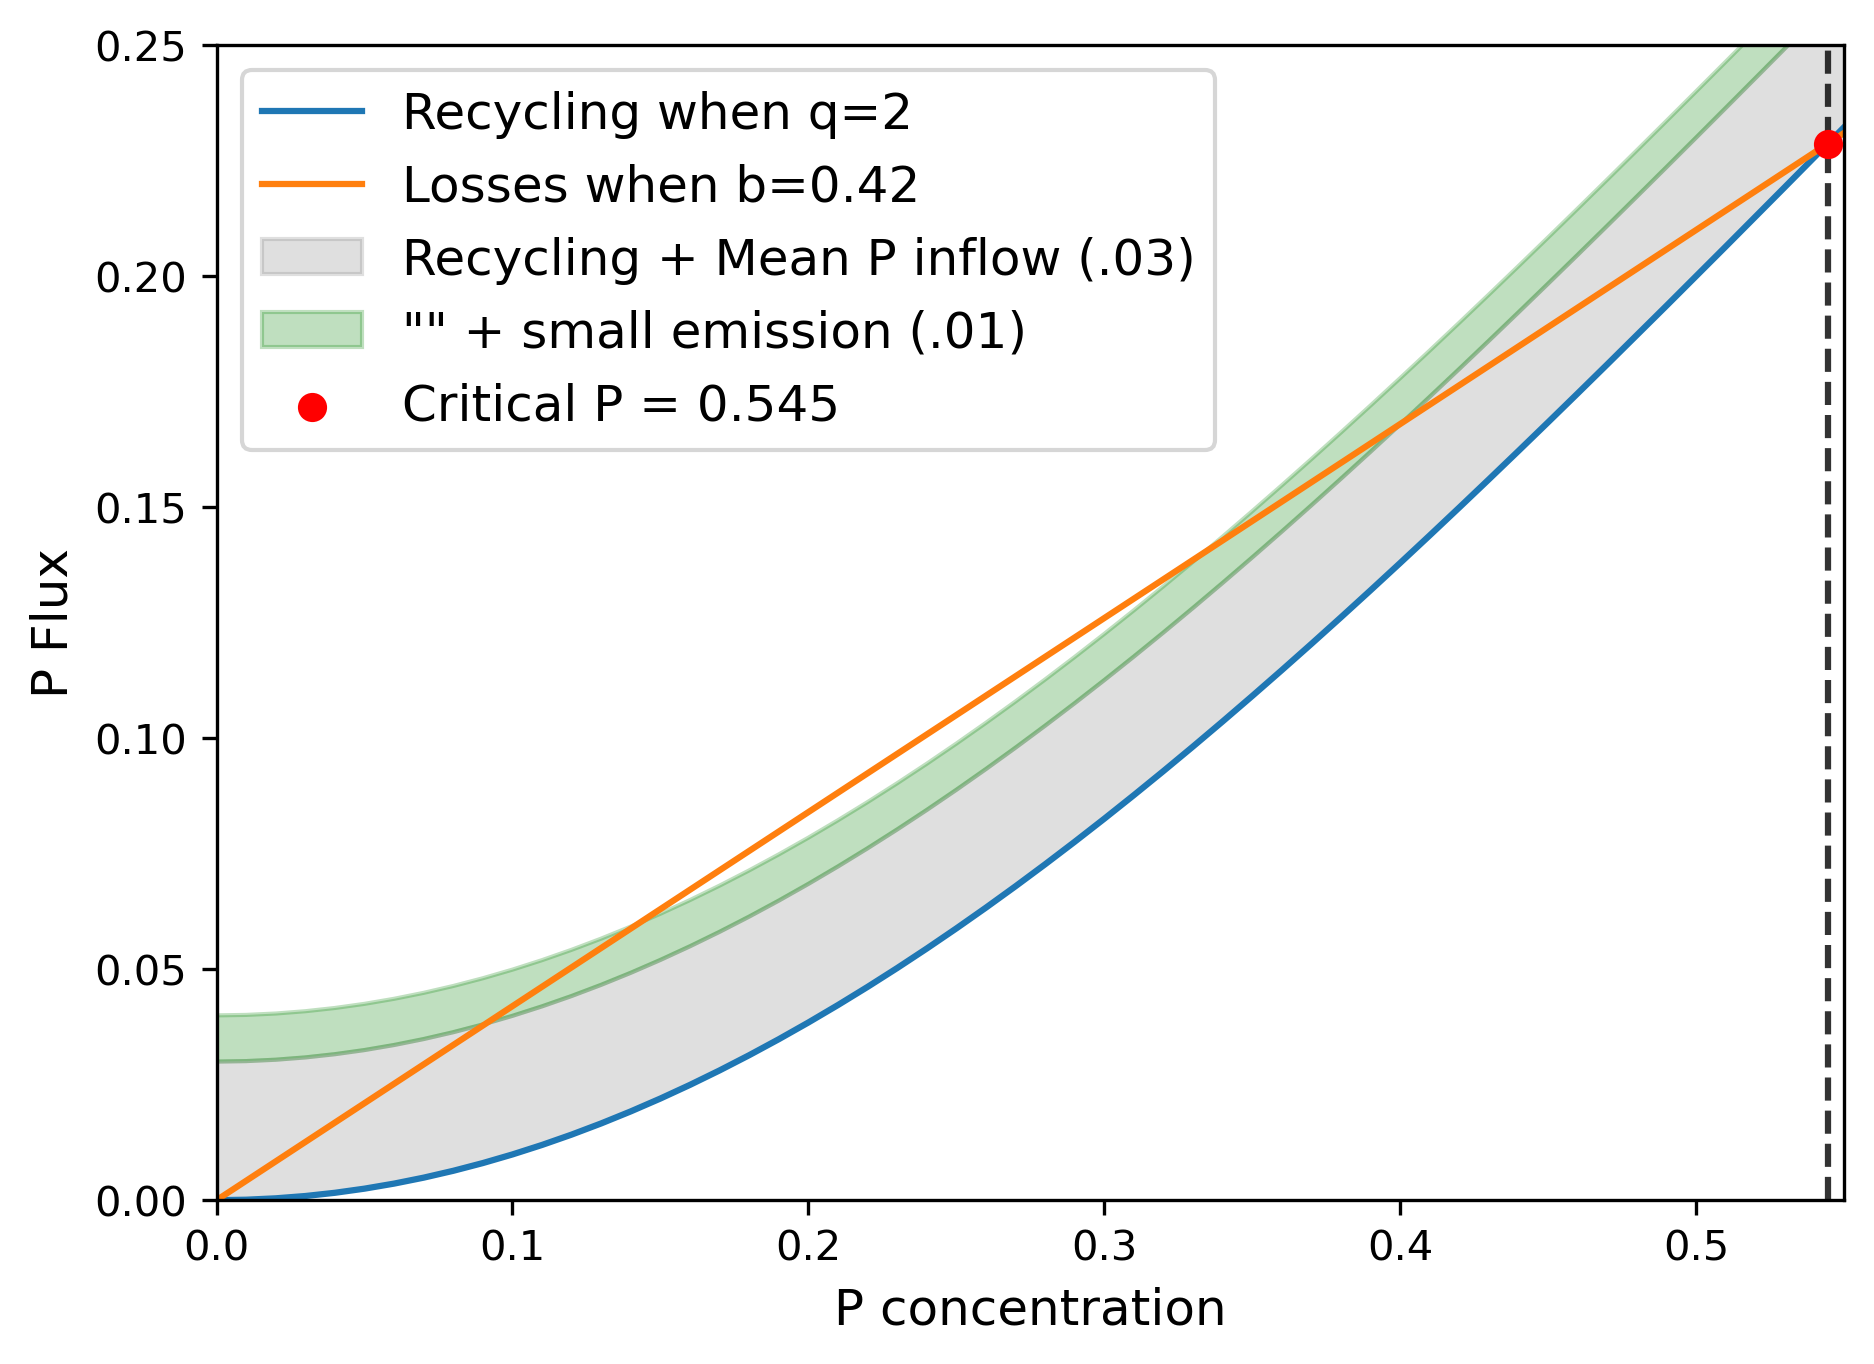

In [11]:
fig, ax = plt.subplots(dpi=300)
ax.plot(xs, R, label="Recycling when q={}".format(q), color="C0")
ax.plot(xs, L, label="Losses when b={}".format(b), color="C1")

ax.fill_between(xs, R, [r + .03 for r in R], label='Recycling + Mean P inflow (.03)', color='gray', alpha=.25)
ax.fill_between(xs, [r + .03 for r in R], [r + .04 for r in R], label='"" + small emission (.01)', color='green', alpha=.25)

ax.axvline(p_crit, color="k", linestyle="--", alpha=0.8)
ax.scatter([p_crit], [recycling(p_crit)], color="red", zorder=5, label=f"Critical P = {p_crit:.3f}")
ax.set_xlabel("P concentration", size=12)
ax.set_ylabel("P Flux", size=12)
ax.set_xlim([0, .55])
ax.set_ylim([0, .25])
ax.legend(fontsize='large')

This plot suggests that even at relatively low P concentrations, the net
P loss that occurs below the critical P threshold might be too low to
support anthropogenic emissions that help us do well on our economic
objective. For example, in between around .18 and .3, we see a very
small margin of net loss. In some realizations, we might get unlucky and
the variance in the natural P inflow will push us into net P gains at
relatively low P concentrations. These P concentrations correspond to
high emission actions for our max benefits policy, quickly taking us
over the critical P threshold.

Note that in the previous plot, the eutrophic realizations that were
below .27 never lose enough P to avoid crossing the threshold (because
we set our min P to .01). The interaction of emitting at least .01,
along with the very small net loss at P concentrations at around .27
means that a year with certain natural P inflows (due to the variance)
will be on its way to the critical P threshold with no turning back.
Instead of a small emission, let’s look at the same plot in terms of our
max benefits and two reliability policies.

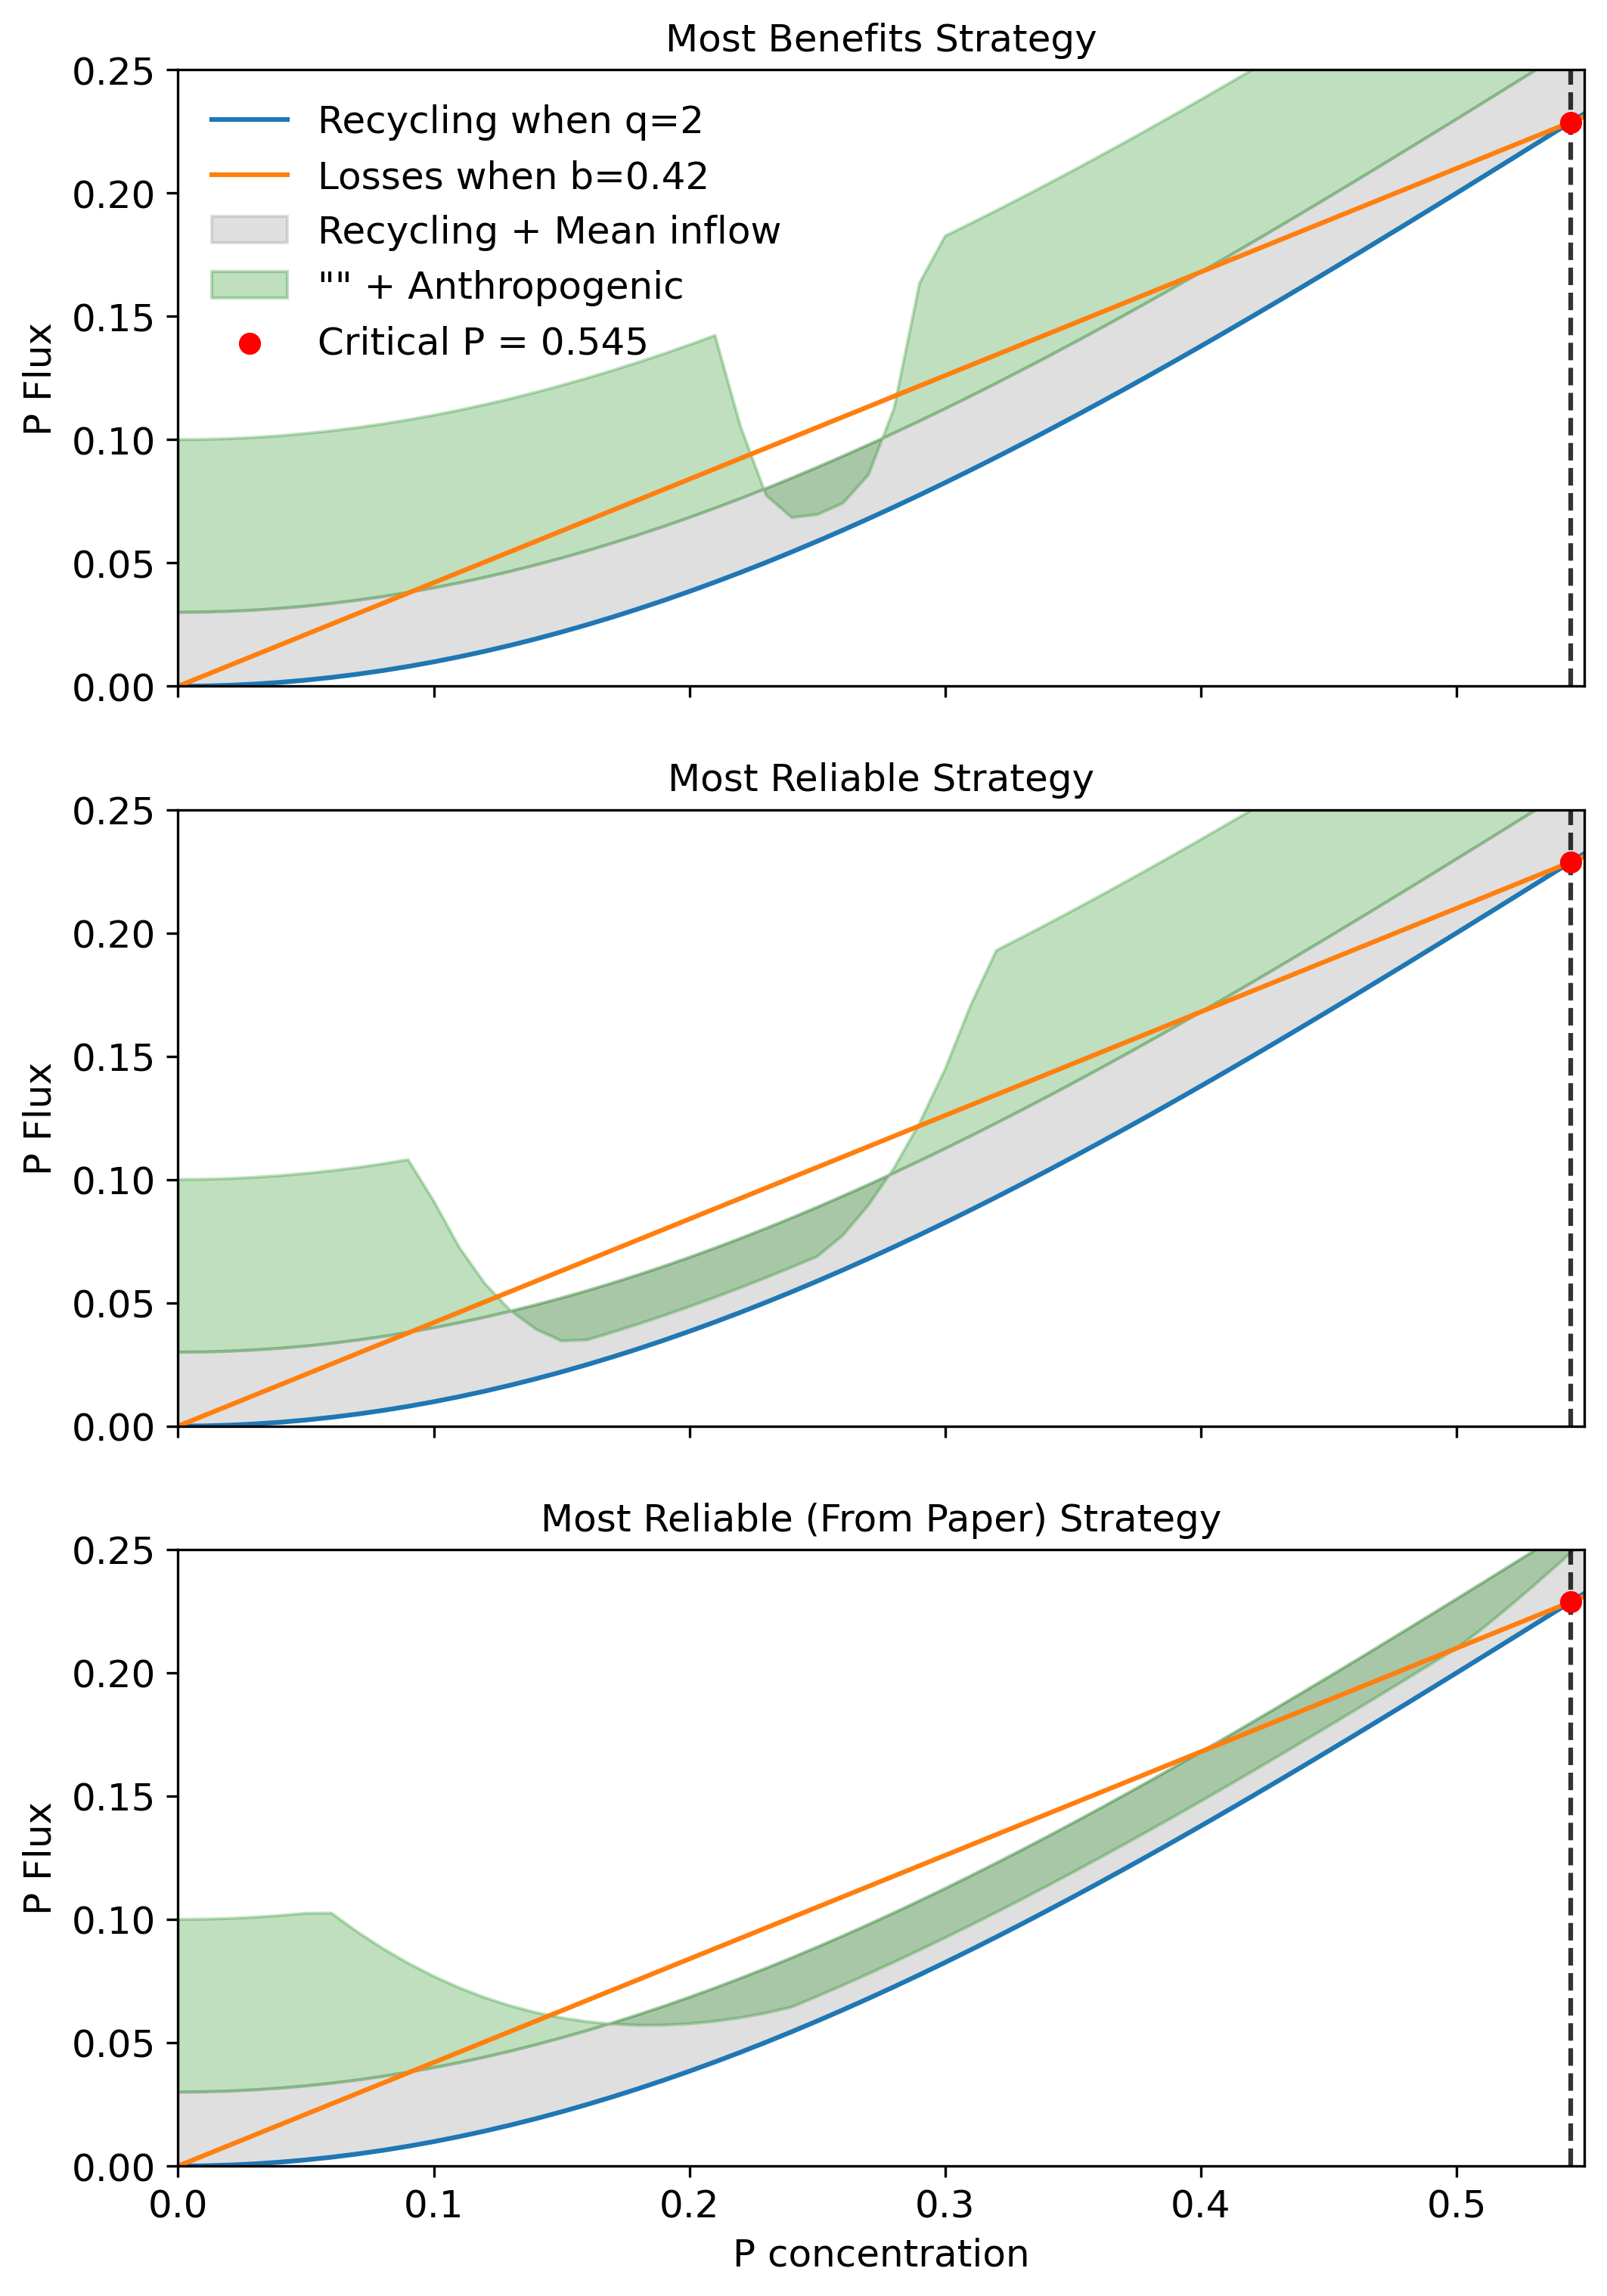

In [12]:
fig, ax = plt.subplots(nrows=3, dpi=300, figsize=(8, 12), sharex=True)

for i, s_group in enumerate(rbfs.groupby(['Strategy'])):

    ax[i].plot(xs, R, label="Recycling when q={}".format(q), color="C0")
    ax[i].plot(xs, L, label="Losses when b={}".format(b), color="C1")

    ax[i].fill_between(xs, R, [r + .03 for r in R], label='Recycling + Mean inflow', color='gray', alpha=.25)
    ax[i].fill_between(xs, [r + .03 for r in R], s_group[1]['Anthropogenic P'].values + np.array(R), label='"" + Anthropogenic', color='green', alpha=.25)

    ax[i].axvline(p_crit, color="k", linestyle="--", alpha=0.8)
    ax[i].scatter([p_crit], [recycling(p_crit)], color="red", zorder=5, label=f"Critical P = {p_crit:.3f}")
    ax[i].set_ylabel("P Flux", size=12)
    ax[i].set_xlim([0, .55])
    ax[i].set_ylim([0, .25])
    ax[i].tick_params('both', labelsize=12)
    ax[i].set_title(s_group[0][0] + " Strategy", size=12)
    if i == 0:
        ax[i].legend(fontsize='large', frameon=False)
    if i == 2:
        ax[i].set_xlabel("P concentration", size=12)

Note the P concentration where the most benefits strategy contributes
its lowest emission. Do the non-eutrophic realizations ever cross this
point?

### Wrapping up lab

In today’s lab, we scrutinized different strategies from the open loop
and closed loop optimization approaches for how they manage the tipping
point dynamics. To wrap up your lab, please include the following
analysis and any visualizations that help you summarize your findings:

1.  Calculate performance metrics for the different strategies we
    reviewed (both the open loop and closed loop) over time across
    realizations.

2.  Calculate the robustness of the most benefits and most reliable
    strategies from the different optimization approaches to different
    SOWs using the same metric as in the paper. I encourage you to check
    the repository and to reproduce figure 8. Do it for intertemporal
    most reliability and most benefits. Then do it for closed loop most
    reliability (you can use either one we looked at - please be
    explicit) and most benefits.

3.  Considering your analysis from #1, our attention to dynamics in lab,
    and the results in Figure 11 in the paper, explain why the different
    optimization approaches (i.e., open vs. closed loop) lead to
    different robustness results.

4.  Considering #3, what would you consider for updating the policy
    search approach to improve robustness while still performing well on
    key objectives in the reference scenario?

5.  Discuss the role that dynamic planning and closed loop optimization
    can play in your decision analysis.

6.  Optional challenge: Can you pinpoint the bifurcation point from the
    most benefits strategy? What dynamics produce this in eutrophication
    realizations? Calibrate your explanation and any figures for a
    non-expert audience, such as a community gathering at town hall
    waiting to hear the results of a scientific assessment for
    regulating emissions into a lake.

    -   Hint: Pay attention to years 1, 2, and 3 and experiment with
        visualizations that help identify a clear signal. You may find
        it helpful to map typical values of eutrophic and non-eutrophic
        states onto the visual language we introduced in the last figure
        of lab.

Please submit your lab report to me as a pdf. Please include a link to
your GitHub repository.